In [1]:
# Optional: quiet JAX TPU noise globally (if you import GEV in this notebook elsewhere)
import os; os.environ["JAX_PLATFORMS"] = "cpu"

from pathlib import Path
import sys, numpy as np, matplotlib.pyplot as plt

# import generator module from same folder
from generator import *

# import GEV from parent if needed
try:
    from GEV import GEV
except ImportError:
    sys.path.insert(0, str(Path.cwd().parent))
    from GEV import GEV

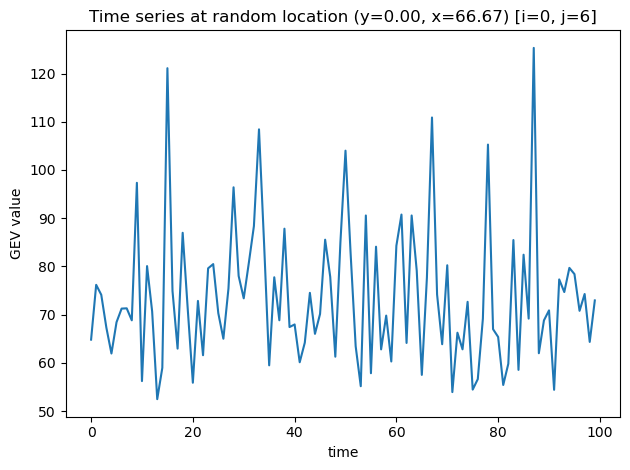

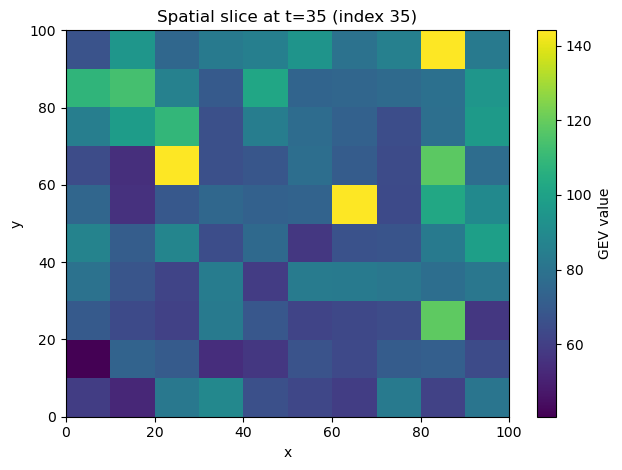

In [32]:
data, meta = generate_gev_dataset_linear(n_lat=10, n_lon=10, n_time=100,
                  beta_mu0=70, beta_mu_t=0, beta_ls0=np.log(11.0),beta_ls_s=0,beta_mu_s=5)
plot_random_time_series(data, meta)
plot_random_spatial_slice(data, meta)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    8.2s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:    8.5s remaining:    0.4s


Success ratio: 1.0


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.9s finished


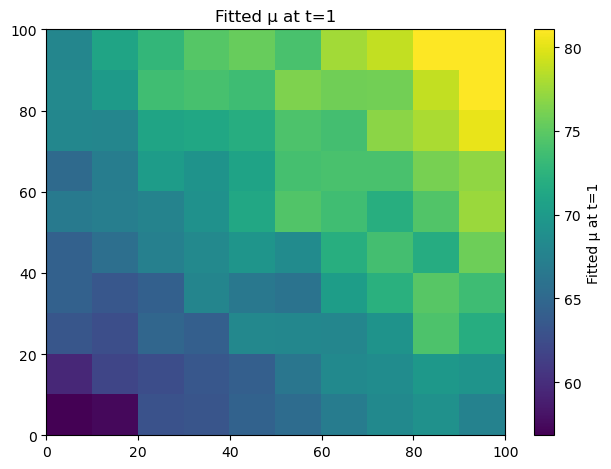

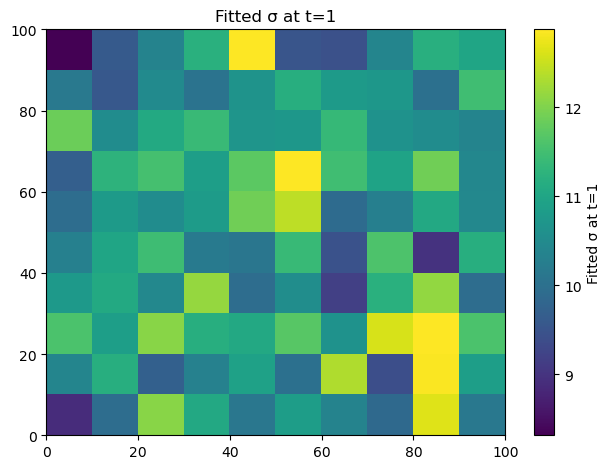

In [33]:
from joblib import Parallel, delayed
def _build_exog_time_only(t_curve):
    X = np.asarray(t_curve, float)[:, None]
    return {"location": None, "scale": None, "shape": None}

def _fit_one(y_t, t_curve, optim_method="L-BFGS-B"):
    try:
        model = GEV(endog=y_t, exog=_build_exog_time_only(t_curve))
        fit = model.fit(optim_method=optim_method, fit_method="MLE")
        iL, iS, iX = model.len_exog
        p = fit.fitted_params
        return True, (iL, iS, iX), p, float(fit.n_ll)
    except Exception as e:
        return False, None, repr(e), np.nan

n_time, n_lat, n_lon = data.shape
jobs = [data[:, i, j].astype(float) for i in range(n_lat) for j in range(n_lon)]
res  = Parallel(n_jobs=-1, backend="loky", verbose=5)(delayed(_fit_one)(y, meta["t_curve"]) for y in jobs)

# unpack to rasters
ok_any = next((r for r in res if r[0]), None)
assert ok_any, "All fits failed."
iL, iS, iX = ok_any[1]
loc_coef = np.full((n_lat, n_lon, iL), np.nan); sca_coef = np.full((n_lat, n_lon, iS), np.nan); xi_coef = np.full((n_lat, n_lon, iX), np.nan)
nll = np.full((n_lat, n_lon), np.nan); ok_mask = np.zeros((n_lat, n_lon), bool)

k = 0
for i in range(n_lat):
    for j in range(n_lon):
        ok, sizes, payload, nll_ij = res[k]; k += 1
        if ok:
            p = payload
            loc_coef[i, j, :] = p[:iL]
            sca_coef[i, j, :] = p[iL:iL+iS]
            xi_coef[i, j, :]  = p[iL+iS:iL+iS+iX]
            nll[i, j] = nll_ij; ok_mask[i, j] = True
        else:
            # payload is error string; you can log if desired
            pass

print("Success ratio:", ok_mask.mean())

def plot_map(field, title, extent=None):
    vmax = float(np.quantile(field[np.isfinite(field)], 0.98))
    plt.figure(); im = plt.imshow(field, origin="lower", extent=extent, aspect="auto", interpolation="none", vmax=vmax)
    plt.colorbar(im, label=title)
    plt.title(title); plt.tight_layout(); plt.show()

rng = np.random.default_rng(123)
k = int(rng.integers(0, n_time)); t_k = float(meta["t_curve"][k])
mu_hat = loc_coef[:, :, 0] + (loc_coef[:, :, 1] if loc_coef.shape[2] > 1 else 0.0) * t_k
sig_hat = sca_coef[:, :, 0] + (sca_coef[:, :, 1] if sca_coef.shape[2] > 1 else 0.0) * t_k
xi_hat = xi_coef[:, :, 0] + (xi_coef[:, :, 1] if xi_coef.shape[2] > 1 else 0.0) * t_k
extent = (meta["x"].min(), meta["x"].max(), meta["y"].min(), meta["y"].max())
plot_map(mu_hat,  f"Fitted μ at t={k}", extent)
plot_map(sig_hat, f"Fitted σ at t={k}", extent)

teacher = {
    "mu_hat":  mu_hat,   # (T,H,W)
    "sigma_hat": sig_hat,
    "xi_hat":  xi_hat,
    "ok_mask": ok_mask,  # True where the fit succeeded
}

Simulations pour les return levels (Marginal en n/2,n/2) (Par exemple ici en 5,5)

In [25]:
import numpy as np
from joblib import Parallel, delayed
from scipy.stats import genextreme

def compute_rl_point(
    generate_fn, gen_kwargs, i, j,
    n_runs=100, T=100, t_idx=25,
    n_jobs_runs=1, backend="loky", optim_method="L-BFGS-B",
    verbose=True, base_seed=2025, confidence=0.95  # NEW
):
    """
    Compute RMSE for pixel (i,j) across n_runs datasets (no file I/O).
    Also computes coverage probability and CI width using the GEV API's
    return-level CIs.

    Returns dict with prior fields plus:
      - coverage_prob     : fraction of successful runs with rl_true in [lo, hi]
      - mean_ci_width     : mean (hi - lo) over successful runs
      - ci_lowers         : per-run lower CI (NaN if failed)
      - ci_uppers         : per-run upper CI (NaN if failed)
      - ci_widths         : per-run CI width (NaN if failed)
      - coverages         : per-run 0/1 indicator (NaN if failed)
      - confidence        : the confidence level used
    """
    def one_run(ridx):
        seed = base_seed + ridx
        try:
            data, meta = generate_fn(**gen_kwargs, seed=seed)

            # --- True RL at (i,j), t_idx for return period T ---
            p_nonexc = 1.0 - 1.0 / float(T)
            mu  = float(meta["mu"][t_idx][i, j])
            sig = float(meta["sigma"][t_idx][i, j])
            xi  = float(meta["xi"][t_idx][i, j])
            rl_true = float(genextreme.ppf(p_nonexc, c=-xi, loc=mu, scale=sig))

            # --- Fit single-series GEV at pixel (i,j) ---
            model = GEV(
                endog=data[:, i, j].astype(float),
                exog={"location": None, "scale": None, "shape": None}
            )
            fit = model.fit(optim_method=optim_method, fit_method="MLE")

            # --- Estimated RL and CI from the API ---
            z, lo, hi = fit.get_return_levels(T=[T], t=[t_idx], s=[0], confidence=confidence)
            rl_hat = float(z[0, 0, 0])
            ci_lo  = float(lo[0, 0, 0])
            ci_hi  = float(hi[0, 0, 0])

            covered  = float(ci_lo <= rl_true <= ci_hi)
            ci_width = float(ci_hi - ci_lo)

            return ridx, rl_hat, rl_true, rl_hat-rl_true, ci_lo, ci_hi, ci_width, covered
        except Exception as e:
            return ridx, np.nan, np.nan, repr(e), np.nan, np.nan, np.nan, np.nan

    # Run simulations (parallel if requested)
    if n_jobs_runs == 1:
        results = [one_run(r) for r in range(n_runs)]
    else:
        results = Parallel(n_jobs=n_jobs_runs, backend=backend, verbose=0)(
            delayed(one_run)(r) for r in range(n_runs)
        )

    # Allocate outputs
    rl_hats    = np.full(n_runs, np.nan)
    rl_trues   = np.full(n_runs, np.nan)
    errors     = [None] * n_runs
    ci_lowers  = np.full(n_runs, np.nan)  # NEW
    ci_uppers  = np.full(n_runs, np.nan)  # NEW
    ci_widths  = np.full(n_runs, np.nan)  # NEW
    coverages  = np.full(n_runs, np.nan)  # NEW

    for ridx, rl_hat, rl_true, err, lo, hi, w, cov in results:
        rl_hats[ridx]   = rl_hat
        rl_trues[ridx]  = rl_true
        errors[ridx]    = err
        ci_lowers[ridx] = lo
        ci_uppers[ridx] = hi
        ci_widths[ridx] = w
        coverages[ridx] = cov

    valid = np.isfinite(rl_hats) & np.isfinite(rl_trues)
    n_successful = int(valid.sum())
    success_rate = n_successful / float(n_runs)

    if n_successful == 0:
        mse = rmse = float("nan")
        mean_true = nrmse_mean = float("nan")
        coverage_prob = mean_ci_width = float("nan")
    else:
        diff = rl_hats[valid] - rl_trues[valid]
        mse  = float(np.mean(diff**2))
        rmse = float(np.sqrt(mse))
        mean_true = float(np.mean(rl_trues[valid]))
        nrmse_mean = float(rmse / abs(mean_true)) if mean_true not in (0.0, -0.0) else np.nan

        # Compute coverage and CI width only over successful runs
        coverage_prob = float(np.nanmean(coverages[valid]))
        mean_ci_width = float(np.nanmean(ci_widths[valid]))

    out = {
        "pixel": (int(i), int(j)),
        "n_runs": int(n_runs),
        "n_successful": n_successful,
        "success_rate": float(success_rate),
        "mse": mse,
        "rmse": rmse,
        "rl_hats": rl_hats,
        "rl_trues": rl_trues,
        "errors": errors,
        "nrmse_mean": float(nrmse_mean),
        # NEW:
        "confidence": float(confidence),
        "coverage_prob": coverage_prob,
        "mean_ci_width": mean_ci_width,
        "ci_lowers": ci_lowers,
        "ci_uppers": ci_uppers,
        "ci_widths": ci_widths,
        "coverages": coverages,
    }

    if verbose:
        cov_str = "nan" if not np.isfinite(coverage_prob) else f"{coverage_prob:.2%}"
        w_str   = "nan" if not np.isfinite(mean_ci_width) else f"{mean_ci_width:.4g}"
        print(
            f"Pixel {i},{j}: runs={n_runs}, success={n_successful} ({success_rate:.2%}), "
            f"RMSE={rmse}, coverage={cov_str} @ {int(confidence*100)}%, mean CI width={w_str}"
        )
        print(f"NRMSE(by mean) = {out['nrmse_mean']}")

    return out

# --------------------------
# Usage example:
# --------------------------
gen_kwargs = dict(n_lat=10, n_lon=10, n_time=100,
                  beta_mu0=70, beta_mu_t=0, beta_ls0=np.log(11.0),beta_ls_s=0,beta_mu_s=5)


res = compute_rl_point(generate_gev_dataset_linear, gen_kwargs,
                         i=5, j=5, n_runs=10, T=100, t_idx=30,
                         n_jobs_runs=4, optim_method="L-BFGS-B", verbose=True)

# in-memory RMSE:
print("RMSE:", res["rmse"])
print(res["errors"])
print(res["coverage_prob"])
print(res["mean_ci_width"])
# per-run estimates available as arrays:
# res["rl_hats"], res["rl_trues"], res["errors"]

Pixel 5,5: runs=10, success=10 (100.00%), RMSE=11.033070011768425, coverage=100.00% @ 95%, mean CI width=46.64
NRMSE(by mean) = 0.0814358972193825
RMSE: 11.033070011768425
[-0.35752327836539166, 12.801107092728358, 2.402043982376796, -14.084917382369298, 8.302755041947108, 23.61116568647836, -2.5915931025841417, -8.118845299849767, -11.51943428910758, 4.169316931595546]
1.0
46.63812408447266


Simulations pour les paramètres (Marginal en n/2,n/2)

In [ ]:
import numpy as np
from joblib import Parallel, delayed


def compute_coeffs_point(
    generate_fn, gen_kwargs, i, j,
    n_runs=100, t_idx=30,
    n_jobs_runs=1, backend="loky", optim_method="L-BFGS-B",
    verbose=True, base_seed=2025,
    confidence=0.95,  # kept for symmetry; fixed at 95% via API
):
    """
    Pointwise (pixel-level) coefficient benchmarking consistent with other coeff methods.

    Truths come from generator betas and the pixel's spatial score s_ij:
      u0_true     = beta_mu0 + beta_mu_s * s_ij
      sigma0_true = exp(beta_ls0 + beta_ls_s * s_ij)
      xi0_true    = beta_xi0 + beta_xi_s * s_ij

    Fit at pixel (i,j): intercept-only GEV (exog=None) -> params [u0, sigma0, xi0].
    CI diagnostics use the API's stored 95% parameter CIs (fit.CIs).
    """

    def one_run(ridx):
        seed = base_seed + ridx
        try:
            # --- simulate one dataset ---
            data, meta = generate_fn(**gen_kwargs, seed=seed)  # (n_time, n_lat, n_lon)
            y = data[:, i, j].astype(float)

            # --- fit intercept-only pointwise model ---
            model = GEV(endog=y, exog={"location": None, "scale": None, "shape": None})
            fit   = model.fit(optim_method=optim_method, fit_method="MLE")

            # --- ground-truth coefficients from generator betas at this pixel ---
            pars = meta["params"]
            s_ij = float(meta["s_field"][i, j])

            u0_true     = float(pars["beta_mu0"] + pars["beta_mu_s"] * s_ij)
            sigma0_true = float(np.exp(pars["beta_ls0"] + pars["beta_ls_s"] * s_ij))
            xi0_true    = float(pars["beta_xi0"] + pars["beta_xi_s"] * s_ij)

            # --- fitted coefficients ---
            theta = np.asarray(fit.fitted_params, float)   # [u0, sigma0, xi0] for intercept-only
            u0_hat, s0_hat, xi_hat = float(theta[0]), float(theta[1]), float(theta[2])

            # --- 95% CIs from API (columns: [lower, upper, p, z/deviance]) ---
            if getattr(fit, "CIs", None) is None:
                lo = np.array([np.nan, np.nan, np.nan], float)
                hi = np.array([np.nan, np.nan, np.nan], float)
            else:
                CIs = np.asarray(fit.CIs, float)
                if CIs.ndim != 2 or CIs.shape[0] < 3 or CIs.shape[1] < 2:
                    lo = np.array([np.nan, np.nan, np.nan], float)
                    hi = np.array([np.nan, np.nan, np.nan], float)
                else:
                    lo = CIs[:3, 0]
                    hi = CIs[:3, 1]

            # widths & coverage vs true coeffs
            w = hi - lo
            cov_u0 = float(lo[0] <= u0_true     <= hi[0]) if np.all(np.isfinite([lo[0], hi[0]])) else np.nan
            cov_s0 = float(lo[1] <= sigma0_true <= hi[1]) if np.all(np.isfinite([lo[1], hi[1]])) else np.nan
            cov_xi = float(lo[2] <= xi0_true    <= hi[2]) if np.all(np.isfinite([lo[2], hi[2]])) else np.nan

            return (
                ridx,
                (u0_hat, s0_hat, xi_hat),
                (u0_true, sigma0_true, xi0_true),
                (lo[0], lo[1], lo[2]),
                (hi[0], hi[1], hi[2]),
                (w[0],  w[1],  w[2]),
                (cov_u0, cov_s0, cov_xi),
                None,
            )
        except Exception as e:
            nan3 = (np.nan, np.nan, np.nan)
            return (ridx, nan3, nan3, nan3, nan3, nan3, nan3, repr(e))

    # ---- run simulations ----
    if n_jobs_runs == 1:
        results = [one_run(r) for r in range(n_runs)]
    else:
        results = Parallel(n_jobs=n_jobs_runs, backend=backend, verbose=0)(
            delayed(one_run)(r) for r in range(n_runs)
        )

    # ---- allocate ----
    u0_hat = np.full(n_runs, np.nan); s0_hat = np.full(n_runs, np.nan); xi_hat = np.full(n_runs, np.nan)
    u0_true_arr = np.full(n_runs, np.nan); s0_true_arr = np.full(n_runs, np.nan); xi_true_arr = np.full(n_runs, np.nan)
    u0_lo = np.full(n_runs, np.nan); u0_hi = np.full(n_runs, np.nan); u0_w = np.full(n_runs, np.nan); u0_cov = np.full(n_runs, np.nan)
    s0_lo = np.full(n_runs, np.nan); s0_hi = np.full(n_runs, np.nan); s0_w = np.full(n_runs, np.nan); s0_cov = np.full(n_runs, np.nan)
    xi_lo = np.full(n_runs, np.nan); xi_hi = np.full(n_runs, np.nan); xi_w = np.full(n_runs, np.nan); xi_cov = np.full(n_runs, np.nan)
    errors = [None] * n_runs

    for ridx, hat_trip, true_trip, lo_trip, hi_trip, w_trip, cov_trip, err in results:
        u0_hat[ridx], s0_hat[ridx], xi_hat[ridx] = hat_trip
        u0_true_arr[ridx], s0_true_arr[ridx], xi_true_arr[ridx] = true_trip
        u0_lo[ridx], s0_lo[ridx], xi_lo[ridx] = lo_trip
        u0_hi[ridx], s0_hi[ridx], xi_hi[ridx] = hi_trip
        u0_w[ridx],  s0_w[ridx],  xi_w[ridx]  = w_trip
        u0_cov[ridx], s0_cov[ridx], xi_cov[ridx] = cov_trip
        errors[ridx] = err

    # ---- masks ----
    valid_u0 = np.isfinite(u0_hat) & np.isfinite(u0_true_arr) & np.isfinite(u0_lo) & np.isfinite(u0_hi)
    valid_s0 = np.isfinite(s0_hat) & np.isfinite(s0_true_arr) & np.isfinite(s0_lo) & np.isfinite(s0_hi)
    valid_xi = np.isfinite(xi_hat) & np.isfinite(xi_true_arr) & np.isfinite(xi_lo) & np.isfinite(xi_hi)
    valid_all = valid_u0 & valid_s0 & valid_xi
    n_successful = int(valid_all.sum())
    success_rate = n_successful / float(n_runs)

    def rmse_mse_bias(hat, tru, mask):
        if mask.sum() == 0: return float("nan"), float("nan"), float("nan")
        diff = hat[mask] - tru[mask]
        mse  = float(np.mean(diff**2))
        rmse = float(np.sqrt(mse))
        bias = float(np.mean(diff))
        return rmse, mse, bias

    rmse_u0, mse_u0, bias_u0 = rmse_mse_bias(u0_hat, u0_true_arr, valid_u0)
    rmse_s0, mse_s0, bias_s0 = rmse_mse_bias(s0_hat, s0_true_arr, valid_s0)
    rmse_xi, mse_xi, bias_xi = rmse_mse_bias(xi_hat, xi_true_arr, valid_xi)

    # NRMSE by |mean true|
    def nrmse_by_mean(rmse, tru_arr, mask):
        mu = float(np.nanmean(tru_arr[mask])) if mask.any() else np.nan
        return rmse / abs(mu) if np.isfinite(rmse) and mu not in (0.0, -0.0) else np.nan

    nrmse_u0_mean = nrmse_by_mean(rmse_u0, u0_true_arr, valid_u0)
    nrmse_s0_mean = nrmse_by_mean(rmse_s0, s0_true_arr, valid_s0)
    nrmse_xi_mean = nrmse_by_mean(rmse_xi, xi_true_arr, valid_xi)

    cov_u0_mean = float(np.nanmean(u0_cov[valid_u0])) if valid_u0.any() else np.nan
    cov_s0_mean = float(np.nanmean(s0_cov[valid_s0])) if valid_s0.any() else np.nan
    cov_xi_mean = float(np.nanmean(xi_cov[valid_xi])) if valid_xi.any() else np.nan

    w_u0_mean = float(np.nanmean(u0_w[valid_u0])) if valid_u0.any() else np.nan
    w_s0_mean = float(np.nanmean(s0_w[valid_s0])) if valid_s0.any() else np.nan
    w_xi_mean = float(np.nanmean(xi_w[valid_xi])) if valid_xi.any() else np.nan

    out = {
        "rmse": {"u0": rmse_u0, "sigma0": rmse_s0, "xi0": rmse_xi},
        "mse":  {"u0": mse_u0,  "sigma0": mse_s0,  "xi0": mse_xi},
        "bias": {"u0": bias_u0, "sigma0": bias_s0, "xi0": bias_xi},
        "n_successful": n_successful,
        "success_rate": float(success_rate),

        "u0_hat": u0_hat, "sigma0_hat": s0_hat, "xi0_hat": xi_hat,
        "u0_true": float(np.nanmean(u0_true_arr)),
        "sigma0_true": float(np.nanmean(s0_true_arr)),
        "xi0_true": float(np.nanmean(xi_true_arr)),
        "errors": errors,
        "pixel": (int(i), int(j)),
        "n_runs": int(n_runs),

        "nrmse_mean": {"u0": float(nrmse_u0_mean), "sigma0": float(nrmse_s0_mean), "xi0": float(nrmse_xi_mean)},

        # Fixed 95% from API CIs
        "confidence": 0.95,
        "coverage_prob": {"u0": cov_u0_mean, "sigma0": cov_s0_mean, "xi0": cov_xi_mean},
        "mean_ci_width": {"u0": w_u0_mean, "sigma0": w_s0_mean, "xi0": w_xi_mean},
        "ci_lowers": {"u0": u0_lo, "sigma0": s0_lo, "xi0": xi_lo},
        "ci_uppers": {"u0": u0_hi, "sigma0": s0_hi, "xi0": xi_hi},
        "ci_widths": {"u0": u0_w, "sigma0": s0_w, "xi0": xi_w},
        "coverages": {"u0": u0_cov, "sigma0": s0_cov, "xi0": xi_cov},
    }

    if verbose:
        print(f"Pixel {i},{j}: runs={n_runs}, success={n_successful} ({success_rate:.2%})")
        print(f"RMSE -> u0: {rmse_u0:.4f}, sigma0: {rmse_s0:.4f}, xi0: {rmse_xi:.4f}")
        print(f"NRMSE(by mean) -> u0: {nrmse_u0_mean:.4f}, sigma0: {nrmse_s0_mean:.4f}, xi0: {nrmse_xi_mean:.4f}")
        print(f"Coverage @ 95% -> u0: "
              f"{'nan' if not np.isfinite(cov_u0_mean) else f'{cov_u0_mean:.2%}'}, "
              f"sigma0: {'nan' if not np.isfinite(cov_s0_mean) else f'{cov_s0_mean:.2%}'}, "
              f"xi0: {'nan' if not np.isfinite(cov_xi_mean) else f'{cov_xi_mean:.2%}'}")
        print(f"Mean CI width -> u0: {w_u0_mean:.4g}, sigma0: {w_s0_mean:.4g}, xi0: {w_xi_mean:.4g}")

    return out

res_coeffs = compute_coeffs_point(
    generate_gev_dataset_linear, gen_kwargs,
    i=5, j=5, n_runs=10, t_idx=30,
    n_jobs_runs=4, optim_method="L-BFGS-B", verbose=True, base_seed=2025
)

Pixel 5,5: runs=10, success=10 (100.00%)
RMSE -> u0: 1.2597, sigma0: 0.8529, xi0: 0.0830
NRMSE(by mean) -> u0: 0.0177, sigma0: 0.0775, xi0: 0.8299
Coverage @ 95% -> u0: 90.00%, sigma0: 100.00%, xi0: 90.00%
Mean CI width -> u0: 4.887, sigma0: 3.525, xi0: 0.2756


Full model RL

In [30]:
import numpy as np
from joblib import Parallel, delayed
from scipy.stats import genextreme

def compute_rl_full(
    generate_fn, gen_kwargs, i, j,
    n_runs=100, T=100, t_idx=25,
    n_jobs_runs=1, backend="threading", optim_method="L-BFGS-B",
    verbose=True, base_seed=2025, confidence=0.95
):
    """
    Fit the full space-time GEV model (all pixels jointly as series) per run,
    then compute the return level at pixel (i,j) for return period T at time t_idx.
    Aggregate across runs to get RMSE and NRMSE(by mean).

    Model (default):
      - location ~ [1, t]            (time covariate; intercept auto-added by GEV)
      - scale    ~ [1]               (intercept only)
      - shape    ~ [1]               (intercept only)

    Returns dict with:
      - rmse, mse
      - nrmse_mean (= RMSE / |mean(true RL)|), nmse_mean (= MSE / mean(true)^2)
      - mean_true (mean RL_true over successful runs)
      - n_successful, success_rate
      - rl_hats, rl_trues (per-run)
      - errors (per-run error strings or None)
    """
    def one_run(ridx):
        seed = base_seed + ridx
        try:
            data, meta = generate_fn(**gen_kwargs, seed=seed)  # data: (n_time, n_lat, n_lon)
            n_time, n_lat, n_lon = data.shape
            s_idx = i * n_lon + j  # series index in the stacked (n_lat*n_lon) block

            # -------- Build multi-series endog block --------
            endog = data.reshape(n_time, n_lat * n_lon).astype(float)  # (n_time, p_series)

            # -------- Exogenous design (broadcast t to all series) --------
            # pass ONLY 't' (no intercept) for location; class will add intercept.
            t_curve = np.asarray(meta["t_curve"], float).reshape(n_time, 1)        # (n_time, 1)
            loc_X   = np.repeat(t_curve[:, :, None], n_lat * n_lon, axis=2)        # (n_time, 1, p_series)
            # scale/shape intercept-only -> pass None (GEV will add intercept column)
            exog = {"location": None, "scale": None, "shape": None}

            # -------- Fit full multi-series model --------
            model = GEV(endog=endog, exog=exog)
            fit   = model._fit_mle_jax()

            # -------- True RL at (i,j), t_idx --------
            p_nonexc = 1.0 - 1.0 / float(T)
            mu   = float(meta["mu"][t_idx][i, j])
            sig  = float(meta["sigma"][t_idx][i, j])
            xi   = float(meta["xi"][t_idx][i, j])
            rl_true = float(genextreme.ppf(p_nonexc, c=-xi, loc=mu, scale=sig))

            # -------- Estimated RL from the full model --------
            z, lo, hi = fit.get_return_levels(T=[T], s=[s_idx], confidence=0.95, t=[None]) #t=[t_idx]
            rl_hat = float(z[0, 0, 0])
            ci_lo  = float(lo[0, 0, 0])   
            ci_hi  = float(hi[0, 0, 0])   

            # --- Coverage & CI width ---
            covered   = float(ci_lo <= rl_true <= ci_hi)  
            ci_width  = float(ci_hi - ci_lo)
            return ridx, rl_hat, rl_true, rl_hat-rl_true, ci_lo, ci_hi, ci_width, covered
        except Exception as e:
            return ridx, np.nan, np.nan, repr(e), np.nan, np.nan, np.nan, np.nan

    # ----- Run simulations (parallel across runs if requested) -----
    if n_jobs_runs == 1:
        results = [one_run(r) for r in range(n_runs)]
    else:
        results = Parallel(n_jobs=n_jobs_runs, backend=backend, verbose=0)(
            delayed(one_run)(r) for r in range(n_runs)
        )

    rl_hats  = np.full(n_runs, np.nan)
    rl_trues = np.full(n_runs, np.nan)
    errors   = [None] * n_runs
    ci_lowers  = np.full(n_runs, np.nan)   
    ci_uppers  = np.full(n_runs, np.nan)   
    ci_widths  = np.full(n_runs, np.nan)   
    coverages  = np.full(n_runs, np.nan)   

    for ridx, rl_hat, rl_true, err, lo, hi, w, cov in results:
        rl_hats[ridx]  = rl_hat
        rl_trues[ridx] = rl_true
        errors[ridx]   = err
        ci_lowers[ridx] = lo
        ci_uppers[ridx] = hi
        ci_widths[ridx] = w
        coverages[ridx] = cov


    valid = np.isfinite(rl_hats) & np.isfinite(rl_trues)
    n_successful = int(valid.sum())
    success_rate = n_successful / float(n_runs)

    if n_successful == 0:
        mse = rmse = mean_true = nrmse_mean = nmse_mean = float("nan")
    
    else:
        diff = rl_hats[valid] - rl_trues[valid]
        mse  = float(np.mean(diff**2))
        rmse = float(np.sqrt(mse))
        mean_true = float(np.mean(rl_trues[valid]))
        nrmse_mean = float(rmse / abs(mean_true)) if mean_true not in (0.0, -0.0) else np.nan
        nmse_mean  = float(mse  / (mean_true**2)) if mean_true not in (0.0, -0.0) else np.nan

        coverage_prob = float(np.nanmean(coverages[valid]))
        mean_ci_width = float(np.nanmean(ci_widths[valid]))

    out = {
        "pixel": (int(i), int(j)),
        "n_runs": int(n_runs),
        "n_successful": n_successful,
        "success_rate": float(success_rate),
        "mse": mse,
        "rmse": rmse,
        "mean_true": mean_true,
        "nrmse_mean": nrmse_mean,   # RMSE / |mean(true RL)|
        "nmse_mean": nmse_mean,     # MSE / mean(true RL)^2
        "rl_hats": rl_hats,
        "rl_trues": rl_trues,
        "errors": errors,
        "confidence": float(confidence),
        "coverage_prob": coverage_prob,     # fraction ∈ [0,1]
        "mean_ci_width": mean_ci_width,     # average (upper - lower)
        "ci_lowers": ci_lowers,
        "ci_uppers": ci_uppers,
        "ci_widths": ci_widths,
        "coverages": coverages,             # 0/1 per run
    }

    if verbose:
        print(f"Pixel {i},{j}: runs={n_runs}, success={n_successful} ({success_rate:.2%})")
        print(f"RMSE ->  T_{T} : {rmse:.4f}")
        print(f"NRMSE(by mean) -> T_{T} : {nrmse_mean:.4f}")
        print(f"Coverage @ 95% -> T_{T} : {coverage_prob:.2%}")
        print(f"Mean CI width -> T_{T} : {mean_ci_width:.4g}")

    return out

res_full = compute_rl_full(
    generate_gev_dataset_linear, gen_kwargs,
    i=5, j=5, n_runs=10, T=100, t_idx=0,
    n_jobs_runs=4, optim_method="L-BFGS-B", verbose=True, base_seed=2025
)


Pixel 5,5: runs=10, success=10 (100.00%)
RMSE ->  T_100 : 3.0211
NRMSE(by mean) -> T_100 : 0.0223
Coverage @ 95% -> T_100 : 20.00%
Mean CI width -> T_100 : 4.022


Full model Coeffs

In [ ]:
def compute_coeffs_full(
    generate_fn, gen_kwargs, i, j,
    n_runs=100,
    n_jobs_runs=1, backend="threading", optim_method="L-BFGS-B",
    verbose=True, base_seed=2025, confidence=0.95  # kept for symmetry with other funcs
):
    """
    Stationary version (no time covariate):
      - location ~ [1]
      - scale    ~ [1]
      - shape    ~ [1]

    Compares fitted intercepts to generator truths:
      u0_true     = beta_mu0
      sigma0_true = exp(beta_ls0)
      xi0_true    = beta_xi0

    Returns dict with RMSE/MSE/bias per parameter, coverage & CI width from API CIs,
    and per-run arrays (hats, CI bounds, widths, coverage flags).
    """

    def one_run(ridx):
        seed = base_seed + ridx
        try:
            # ----- simulate -----
            data, meta = generate_fn(**gen_kwargs, seed=seed)  # (n_time, n_lat, n_lon)
            n_time, n_lat, n_lon = data.shape

            # ----- build multi-series endog (stack series), intercept-only exog -----
            endog = data.reshape(n_time, n_lat * n_lon).astype(float)
            exog = {"location": None, "scale": None, "shape": None}  # intercept-only for all

            # ----- fit full model (JAX MLE) -----
            model = GEV(endog=endog, exog=exog)
            fit   = model._fit_mle_jax()  # GEVFit with 95% CIs in fit.CIs

            # index mapping (intercept-only => i_len=j_len=k_len=1)
            i_len, j_len, k_len = fit.gevSample.len_exog  # should be (1,1,1)
            idx_u0  = 0
            idx_s0  = i_len            # 1
            idx_xi0 = i_len + j_len    # 2

            # hats
            theta = np.asarray(fit.fitted_params, float)
            u0_hat   = float(theta[idx_u0])
            s0_hat   = float(theta[idx_s0])
            xi0_hat  = float(theta[idx_xi0])

            # true coeffs from generator params (stationary truths)
            pars = meta["params"]
            u0_true    = float(pars["beta_mu0"])
            sigma0_true= float(np.exp(pars["beta_ls0"]))
            xi0_true   = float(pars["beta_xi0"])

            # 95% CIs straight from API: columns [lower, upper, p, z/deviance]
            if getattr(fit, "CIs", None) is None:
                lo = hi = None
            else:
                CIs = np.asarray(fit.CIs, float)
                lo = CIs[:, 0] if CIs.ndim == 2 and CIs.shape[1] >= 2 else None
                hi = CIs[:, 1] if CIs.ndim == 2 and CIs.shape[1] >= 2 else None

            def pick_bounds(idx):
                if lo is None or hi is None or idx is None or idx >= len(lo):
                    return np.nan, np.nan
                return float(lo[idx]), float(hi[idx])

            u0_lo, u0_hi   = pick_bounds(idx_u0)
            s0_lo, s0_hi   = pick_bounds(idx_s0)
            xi_lo, xi_hi   = pick_bounds(idx_xi0)

            u0_w  = u0_hi - u0_lo if np.isfinite(u0_lo) and np.isfinite(u0_hi) else np.nan
            s0_w  = s0_hi - s0_lo if np.isfinite(s0_lo) and np.isfinite(s0_hi) else np.nan
            xi_w  = xi_hi - xi_lo if np.isfinite(xi_lo) and np.isfinite(xi_hi) else np.nan

            u0_cov = float(u0_lo <= u0_true     <= u0_hi) if np.isfinite(u0_lo) and np.isfinite(u0_hi) else np.nan
            s0_cov = float(s0_lo <= sigma0_true <= s0_hi) if np.isfinite(s0_lo) and np.isfinite(s0_hi) else np.nan
            xi_cov = float(xi_lo <= xi0_true    <= xi_hi) if np.isfinite(xi_lo) and np.isfinite(xi_hi) else np.nan

            return (
                ridx,
                (u0_hat, s0_hat, xi0_hat),
                (u0_true, sigma0_true, xi0_true),
                (u0_lo,  s0_lo,  xi_lo),
                (u0_hi,  s0_hi,  xi_hi),
                (u0_w,   s0_w,   xi_w),
                (u0_cov, s0_cov, xi_cov),
                None,
            )
        except Exception as e:
            nan3 = (np.nan, np.nan, np.nan)
            return (ridx, nan3, nan3, nan3, nan3, nan3, nan3, repr(e))

    # ----- run simulations -----
    if n_jobs_runs == 1:
        results = [one_run(r) for r in range(n_runs)]
    else:
        results = Parallel(n_jobs=n_jobs_runs, backend=backend, verbose=0)(
            delayed(one_run)(r) for r in range(n_runs)
        )

    # allocate per-run arrays (u0, sigma0, xi0)
    u0_hat = np.full(n_runs, np.nan); s0_hat = np.full(n_runs, np.nan); xi0_hat = np.full(n_runs, np.nan)
    u0_true_arr = np.full(n_runs, np.nan); s0_true_arr = np.full(n_runs, np.nan); xi0_true_arr = np.full(n_runs, np.nan)

    u0_lo = np.full(n_runs, np.nan); s0_lo = np.full(n_runs, np.nan); xi_lo = np.full(n_runs, np.nan)
    u0_hi = np.full(n_runs, np.nan); s0_hi = np.full(n_runs, np.nan); xi_hi = np.full(n_runs, np.nan)

    u0_w  = np.full(n_runs, np.nan); s0_w  = np.full(n_runs, np.nan); xi_w  = np.full(n_runs, np.nan)
    u0_cov= np.full(n_runs, np.nan); s0_cov= np.full(n_runs, np.nan); xi_cov= np.full(n_runs, np.nan)

    errors = [None] * n_runs

    for ridx, hats, trues, los, his, ws, covs, err in results:
        u0_hat[ridx], s0_hat[ridx], xi0_hat[ridx] = hats
        u0_true_arr[ridx], s0_true_arr[ridx], xi0_true_arr[ridx] = trues
        u0_lo[ridx], s0_lo[ridx], xi_lo[ridx] = los
        u0_hi[ridx], s0_hi[ridx], xi_hi[ridx] = his
        u0_w[ridx],  s0_w[ridx],  xi_w[ridx]  = ws
        u0_cov[ridx], s0_cov[ridx], xi_cov[ridx] = covs
        errors[ridx] = err

    # validity per parameter
    v_u0 = np.isfinite(u0_hat) & np.isfinite(u0_true_arr)
    v_s0 = np.isfinite(s0_hat) & np.isfinite(s0_true_arr)
    v_xi = np.isfinite(xi0_hat) & np.isfinite(xi0_true_arr)
    valid_all = v_u0 & v_s0 & v_xi

    n_successful = int(valid_all.sum())
    success_rate = n_successful / float(n_runs)

    def rmse_mse_bias(hat, tru, mask):
        if mask.sum() == 0:
            return float("nan"), float("nan"), float("nan")
        diff = hat[mask] - tru[mask]
        mse  = float(np.mean(diff**2))
        rmse = float(np.sqrt(mse))
        bias = float(np.mean(diff))
        return rmse, mse, bias

    rmse_u0, mse_u0, bias_u0 = rmse_mse_bias(u0_hat, u0_true_arr, v_u0)
    rmse_s0, mse_s0, bias_s0 = rmse_mse_bias(s0_hat, s0_true_arr, v_s0)
    rmse_xi, mse_xi, bias_xi = rmse_mse_bias(xi0_hat, xi0_true_arr, v_xi)

    # NRMSE by |mean true|
    def nrmse_by_mean(rmse, tru_arr, mask):
        mu = float(np.nanmean(tru_arr[mask])) if mask.any() else np.nan
        return rmse / abs(mu) if np.isfinite(rmse) and mu not in (0.0, -0.0) else np.nan

    nrmse_u0 = nrmse_by_mean(rmse_u0, u0_true_arr, v_u0)
    nrmse_s0 = nrmse_by_mean(rmse_s0, s0_true_arr, v_s0)
    nrmse_xi = nrmse_by_mean(rmse_xi, xi0_true_arr, v_xi)

    # coverage prob & mean CI width per parameter (from API CIs)
    cov_u0_mean = float(np.nanmean(u0_cov[v_u0])) if v_u0.any() else np.nan
    cov_s0_mean = float(np.nanmean(s0_cov[v_s0])) if v_s0.any() else np.nan
    cov_xi_mean = float(np.nanmean(xi_cov[v_xi])) if v_xi.any() else np.nan

    w_u0_mean = float(np.nanmean(u0_w[v_u0])) if v_u0.any() else np.nan
    w_s0_mean = float(np.nanmean(s0_w[v_s0])) if v_s0.any() else np.nan
    w_xi_mean = float(np.nanmean(xi_w[v_xi])) if v_xi.any() else np.nan

    out = {
        "pixel": (int(i), int(j)),
        "n_runs": int(n_runs),
        "n_successful": n_successful,
        "success_rate": float(success_rate),

        "rmse": {"u0": rmse_u0, "sigma0": rmse_s0, "xi0": rmse_xi},
        "mse":  {"u0": mse_u0,  "sigma0": mse_s0, "xi0": mse_xi},
        "bias": {"u0": bias_u0, "sigma0": bias_s0, "xi0": bias_xi},

        "u0_hat": u0_hat, "sigma0_hat": s0_hat, "xi0_hat": xi0_hat,
        "u0_true": float(np.nanmean(u0_true_arr)),         # constant across runs
        "sigma0_true": float(np.nanmean(s0_true_arr)),
        "xi0_true": float(np.nanmean(xi0_true_arr)),
        "errors": errors,

        "nrmse_mean": {"u0": float(nrmse_u0), "sigma0": float(nrmse_s0), "xi0": float(nrmse_xi)},

        "confidence": 0.95,
        "coverage_prob": {"u0": cov_u0_mean, "sigma0": cov_s0_mean, "xi0": cov_xi_mean},
        "mean_ci_width": {"u0": w_u0_mean, "sigma0": w_s0_mean, "xi0": w_xi_mean},

        "ci_lowers": {"u0": u0_lo, "sigma0": s0_lo, "xi0": xi_lo},
        "ci_uppers": {"u0": u0_hi, "sigma0": s0_hi, "xi0": xi_hi},
        "ci_widths": {"u0": u0_w,  "sigma0": s0_w,  "xi0": xi_w},
        "coverages": {"u0": u0_cov, "sigma0": s0_cov, "xi0": xi_cov},
    }

    if verbose:
        print(f"(full-model coeffs, stationary) runs={n_runs}, success={n_successful} ({success_rate:.2%})")
        print(f"RMSE -> u0: {rmse_u0:.4f}, sigma0: {rmse_s0:.4f}, xi0: {rmse_xi:.4f}")
        print(f"NRMSE(by mean) -> u0: {nrmse_u0:.4f}, sigma0: {nrmse_s0:.4f}, xi0: {nrmse_xi:.4f}")
        print(f"Coverage @ 95% -> "
              f"u0: {'nan' if not np.isfinite(cov_u0_mean) else f'{cov_u0_mean:.2%}'}, "
              f"sigma0: {'nan' if not np.isfinite(cov_s0_mean) else f'{cov_s0_mean:.2%}'}, "
              f"xi0: {'nan' if not np.isfinite(cov_xi_mean) else f'{cov_xi_mean:.2%}'}")
        print(f"Mean CI width -> u0: {w_u0_mean:.4g}, sigma0: {w_s0_mean:.4g}, xi0: {w_xi_mean:.4g}")

    return out

res_full = compute_coeffs_full(
    generate_gev_dataset_linear, gen_kwargs,
    i=5, j=5, n_runs=100,
    n_jobs_runs=4, optim_method="L-BFGS-B", verbose=True, base_seed=2025
)


(full-model coeffs, stationary) runs=10, success=10 (100.00%)
RMSE -> u0: 0.1116, sigma0: 1.6084, xi0: 0.0673
NRMSE(by mean) -> u0: 0.0016, sigma0: 0.1462, xi0: 0.6732
Coverage @ 95% -> u0: 90.00%, sigma0: 0.00%, xi0: 0.00%
Mean CI width -> u0: 0.4776, sigma0: 0.3876, xi0: 0.02632


In [48]:
def compute_rl_weighted(
    generate_fn, gen_kwargs, i, j,
    *, 
    kernel_weight,                 # fn(d_mu, d_logsig, d_xi) -> weights in (0,1)
    t_idx: int = 0,                # fixed reference time (stationary)
    n_runs=100, T=100,
    n_jobs_runs=1, backend="threading", optim_method="L-BFGS-B",
    verbose=True, base_seed=2025, min_weight=0.0,
    confidence: float = 0.95,
):
    """
    Weighted full model under temporal stationarity.
    - Intercept-only GEV: location ~ [1], scale ~ [1], shape ~ [1]
    - Weights are computed once at t_ref and repeated for all times.
    - Truth RL is evaluated from meta at t_ref (stationary => any t works).
    - Reports RMSE, coverage probability, and mean CI width for the T-year RL.
    """

    def _weights_from_meta_stationary(meta, ii, jj, t_ref):
        """Build W[t, s] constant in time, based on distances at t_ref."""
        mu   = np.asarray(meta["mu"],    dtype=np.float32)   # (n_time, n_lat, n_lon)
        sig  = np.asarray(meta["sigma"], dtype=np.float32)
        xi   = np.asarray(meta["xi"],    dtype=np.float32)
        logs = np.log(np.clip(sig, 1e-12, None))

        n_time, n_lat, n_lon = mu.shape
        n_series = n_lat * n_lon

        tref = int(np.clip(t_idx, 0, n_time - 1))
        mu_ref, logs_ref, xi_ref = float(mu[tref, ii, jj]), float(logs[tref, ii, jj]), float(xi[tref, ii, jj])

        # distances at the single reference time
        mu_flat   = mu[tref].reshape(n_series)     # (S,)
        logs_flat = logs[tref].reshape(n_series)
        xi_flat   = xi[tref].reshape(n_series)

        d_mu   = np.abs(mu_flat   - mu_ref)
        d_lsig = np.abs(logs_flat - logs_ref)
        d_xi   = np.abs(xi_flat   - xi_ref)

        w = kernel_weight(d_mu, d_lsig, d_xi).astype(np.float32)  # (S,)
        if min_weight > 0.0:
            np.maximum(w, min_weight, out=w)

        # tile across time -> (T, S)
        W = np.tile(w[None, :], (n_time, 1))
        return W

    def one_run(ridx):
        seed = base_seed + ridx
        try:
            data, meta = generate_fn(**gen_kwargs, seed=seed)  # (n_time, n_lat, n_lon)
            n_time, n_lat, n_lon = data.shape
            s_idx = i * n_lon + j

            # ---- time-constant weights ----
            weights = _weights_from_meta_stationary(meta, i, j, t_idx)  # (n_time, n_series)

            # ---- endog (stack series) ----
            endog = data.reshape(n_time, n_lat * n_lon).astype(float)

            # ---- intercept-only (stationary) ----
            exog = {"location": None, "scale": None, "shape": None}

            # ---- fit weighted stationary model ----
            model = GEV(endog=endog, exog=exog, weights=weights)
            fit   = model._fit_mle_jax()  # or model.fit(optim_method=optim_method, fit_method="MLE")

            # ---- true RL at (i,j) using t_ref ----
            p_nonexc = 1.0 - 1.0 / float(T)
            mu_true  = float(meta["mu"][t_idx,  i, j])
            sig_true = float(meta["sigma"][t_idx, i, j])
            xi_true  = float(meta["xi"][t_idx,  i, j])
            rl_true  = float(genextreme.ppf(p_nonexc, c=-xi_true, loc=mu_true, scale=sig_true))

            # ---- estimated RL + CI (stationary => t is ignored; pass None) ----
            z, lo, hi = fit.get_return_levels(T=[T], t=[None], s=[s_idx], confidence=confidence)
            rl_hat = float(z[0, 0, 0])
            ci_lo  = float(lo[0, 0, 0])
            ci_hi  = float(hi[0, 0, 0])

            covered  = float(ci_lo <= rl_true <= ci_hi)
            ci_width = float(ci_hi - ci_lo)

            return ridx, rl_hat, rl_true, None, ci_lo, ci_hi, ci_width, covered
        except Exception as e:
            return ridx, np.nan, np.nan, repr(e), np.nan, np.nan, np.nan, np.nan

    # ----- Run simulations -----
    results = (Parallel(n_jobs=n_jobs_runs, backend=backend, verbose=0)
               (delayed(one_run)(r) for r in range(n_runs))) if n_jobs_runs != 1 else [one_run(r) for r in range(n_runs)]

    # ----- Collect -----
    rl_hats   = np.full(n_runs, np.nan)
    rl_trues  = np.full(n_runs, np.nan)
    errors    = [None] * n_runs
    ci_lowers = np.full(n_runs, np.nan)
    ci_uppers = np.full(n_runs, np.nan)
    ci_widths = np.full(n_runs, np.nan)
    coverages = np.full(n_runs, np.nan)

    for ridx, rl_hat, rl_true, err, lo, hi, w, cov in results:
        rl_hats[ridx]   = rl_hat
        rl_trues[ridx]  = rl_true
        errors[ridx]    = err
        ci_lowers[ridx] = lo
        ci_uppers[ridx] = hi
        ci_widths[ridx] = w
        coverages[ridx] = cov

    valid = np.isfinite(rl_hats) & np.isfinite(rl_trues)
    n_successful = int(valid.sum())
    success_rate = n_successful / float(n_runs)

    valid_ci = valid & np.isfinite(ci_lowers) & np.isfinite(ci_uppers)

    if n_successful == 0:
        mse = rmse = mean_true = nrmse_mean = nmse_mean = float("nan")
        coverage_prob = mean_ci_width = float("nan")
    else:
        diff = rl_hats[valid] - rl_trues[valid]
        mse  = float(np.mean(diff**2))
        rmse = float(np.sqrt(mse))
        mean_true = float(np.mean(rl_trues[valid]))
        nrmse_mean = float(rmse / abs(mean_true)) if mean_true not in (0.0, -0.0) else np.nan
        nmse_mean  = float(mse  / (mean_true**2)) if mean_true not in (0.0, -0.0) else np.nan

        coverage_prob = float(np.nanmean(coverages[valid_ci])) if np.any(valid_ci) else float("nan")
        mean_ci_width = float(np.nanmean(ci_widths[valid_ci])) if np.any(valid_ci) else float("nan")

    if verbose:
        cov_str = "nan" if not np.isfinite(coverage_prob) else f"{coverage_prob:.2%}"
        w_str   = "nan" if not np.isfinite(mean_ci_width) else f"{mean_ci_width:.4g}"
        print(f"(weighted stationary) pixel {i},{j}: runs={n_runs}, success={n_successful} ({success_rate:.2%}), "
              f"RMSE={rmse}, NRMSE(mean)={nrmse_mean}, coverage={cov_str} @ {int(confidence*100)}%, "
              f"mean CI width={w_str}")

    return {
        "pixel": (int(i), int(j)),
        "n_runs": int(n_runs),
        "n_successful": n_successful,
        "success_rate": success_rate,
        "mse": mse,
        "rmse": rmse,
        "mean_true": mean_true,
        "nrmse_mean": nrmse_mean,
        "nmse_mean": nmse_mean,
        "confidence": float(confidence),
        "coverage_prob": coverage_prob,
        "mean_ci_width": mean_ci_width,
        "rl_hats": rl_hats,
        "rl_trues": rl_trues,
        "ci_lowers": ci_lowers,
        "ci_uppers": ci_uppers,
        "ci_widths": ci_widths,
        "coverages": coverages,
        "errors": errors,
    }

kernel_weight = make_kernel_weight(net, mu_scale, logsig_scale, xi_scale)

res_weighted = compute_rl_weighted(
    generate_gev_dataset_linear, gen_kwargs,
    i=5, j=5, n_runs=100, T=100, t_idx=30,
    kernel_weight=kernel_weight,           # ← here                # or "fixed" with t_idx_fixed=...
    n_jobs_runs=4, optim_method="L-BFGS-B", verbose=True, base_seed=2025
)


print("RMSE:", res_weighted["rmse"])
print("nrmse_mean:", res_weighted["nrmse_mean"])
print("coverage_prob:", res_weighted["coverage_prob"])
print("coverage_prob:", res_weighted["mean_ci_width"])

(weighted stationary) pixel 5,5: runs=100, success=100 (100.00%), RMSE=1.7930270019022612, NRMSE(mean)=0.013234463524906601, coverage=89.00% @ 95%, mean CI width=6.764
RMSE: 1.7930270019022612
nrmse_mean: 0.013234463524906601
coverage_prob: 0.89
coverage_prob: 6.7641917419433595


In [47]:
def compute_coeffs_weighted(
    generate_fn, gen_kwargs, i, j,
    *, 
    kernel_weight,                 # fn(d_mu, d_logsig, d_xi) -> weights in (0,1)
    t_ref: int = 0,                # fixed reference time for weights/truths
    n_runs=100,
    n_jobs_runs=1, backend="threading", optim_method="L-BFGS-B",
    verbose=True, base_seed=2025, min_weight=0.0,
    confidence: float = 0.95,      # for symmetry; CIs come from fit.CIs
):
    """
    Stationary, weighted full-model *coefficients* benchmarking.
    Model: location ~ [1]; scale ~ [1]; shape ~ [1].
    Weights are computed once at t_ref from (Δμ, Δlogσ, Δξ) and tiled across time.

    Truths use kernel-weighted spatial mean s̄_w:
      s̄_w = sum_s w_s * s[s] / sum_s w_s   (with w_s = sum_t W[t,s], but W is constant over t here)
      u0_true     = beta_mu0 + beta_mu_s * s̄_w
      sigma0_true = exp(beta_ls0 + beta_ls_s * s̄_w)
      xi0_true    = beta_xi0 + beta_xi_s * s̄_w
    """

    def _weights_from_meta_stationary(meta, ii, jj, t_ref):
        """Compute a single (time-constant) weight vector at t_ref and tile across time."""
        mu   = np.asarray(meta["mu"],    dtype=np.float32)   # (n_time, n_lat, n_lon)
        sig  = np.asarray(meta["sigma"], dtype=np.float32)
        xi   = np.asarray(meta["xi"],    dtype=np.float32)
        logs = np.log(np.clip(sig, 1e-12, None))

        n_time, n_lat, n_lon = mu.shape
        n_series = n_lat * n_lon

        tref = int(np.clip(t_ref, 0, n_time - 1))
        mu_ref, logs_ref, xi_ref = float(mu[tref, ii, jj]), float(logs[tref, ii, jj]), float(xi[tref, ii, jj])

        # distances at reference time
        mu_flat   = mu[tref].reshape(n_series)
        logs_flat = logs[tref].reshape(n_series)
        xi_flat   = xi[tref].reshape(n_series)

        d_mu   = np.abs(mu_flat   - mu_ref)
        d_lsig = np.abs(logs_flat - logs_ref)
        d_xi   = np.abs(xi_flat   - xi_ref)

        w = kernel_weight(d_mu, d_lsig, d_xi).astype(np.float32)  # (S,)
        if min_weight > 0.0:
            np.maximum(w, min_weight, out=w)

        # tile across time -> (T, S)
        W = np.tile(w[None, :], (n_time, 1))
        return W

    def one_run(ridx):
        seed = base_seed + ridx
        try:
            # ---- simulate ----
            data, meta = generate_fn(**gen_kwargs, seed=seed)  # (n_time, n_lat, n_lon)
            n_time, n_lat, n_lon = data.shape

            # ---- weights (constant over time) ----
            W = _weights_from_meta_stationary(meta, i, j, t_ref)  # (n_time, n_series)
            W_sum = float(W.sum()) if np.isfinite(W).all() else float(np.nansum(W))
            if not np.isfinite(W_sum) or W_sum <= 0:
                raise ValueError("Invalid or zero total weight.")

            # ---- endog/exog (intercept-only) ----
            endog = data.reshape(n_time, n_lat * n_lon).astype(float)
            exog = {"location": None, "scale": None, "shape": None}

            # ---- fit stationary weighted model ----
            model = GEV(endog=endog, exog=exog, weights=W)
            fit   = model._fit_mle_jax()  # or: model.fit(optim_method=optim_method, fit_method="MLE")

            # ---- parameter indices (i_len=j_len=k_len=1) ----
            i_len, j_len, k_len = fit.gevSample.len_exog
            idx_u0  = 0
            idx_s0  = i_len           # 1
            idx_xi0 = i_len + j_len   # 2

            # ---- hats ----
            theta = np.asarray(fit.fitted_params, float)
            u0_hat   = float(theta[idx_u0])
            s0_hat   = float(theta[idx_s0])
            xi0_hat  = float(theta[idx_xi0])

            # ---- kernel-weighted truths (spatial only) ----
            pars = meta["params"]
            s_flat = np.asarray(meta["s_field"], float).reshape(-1)   # (S,)
            w_s    = W.sum(axis=0)                                    # weight per series
            s_bar  = float(np.dot(s_flat, w_s) / W_sum)

            u0_true     = float(pars["beta_mu0"]  + pars["beta_mu_s"]  * s_bar)
            sigma0_true = float(np.exp(pars["beta_ls0"] + pars["beta_ls_s"] * s_bar))
            xi0_true    = float(pars["beta_xi0"]  + pars["beta_xi_s"]  * s_bar)

            # ---- 95% CIs from API ----
            CIs = getattr(fit, "CIs", None)
            if CIs is not None and np.ndim(CIs) == 2 and CIs.shape[1] >= 2:
                CIs = np.asarray(CIs, float)
                lo, hi = CIs[:, 0], CIs[:, 1]
            else:
                lo = hi = None

            def bounds(idx):
                if lo is None or hi is None or idx is None or idx >= len(lo):
                    return np.nan, np.nan
                return float(lo[idx]), float(hi[idx])

            u0_lo, u0_hi = bounds(idx_u0)
            s0_lo, s0_hi = bounds(idx_s0)
            xi_lo, xi_hi = bounds(idx_xi0)

            u0_w = u0_hi - u0_lo if np.isfinite(u0_lo) and np.isfinite(u0_hi) else np.nan
            s0_w = s0_hi - s0_lo if np.isfinite(s0_lo) and np.isfinite(s0_hi) else np.nan
            xi_w = xi_hi - xi_lo if np.isfinite(xi_lo) and np.isfinite(xi_hi) else np.nan

            u0_cov = float(u0_lo <= u0_true     <= u0_hi) if np.isfinite(u0_lo) and np.isfinite(u0_hi) else np.nan
            s0_cov = float(s0_lo <= sigma0_true <= s0_hi) if np.isfinite(s0_lo) and np.isfinite(s0_hi) else np.nan
            xi_cov = float(xi_lo <= xi0_true    <= xi_hi) if np.isfinite(xi_lo) and np.isfinite(xi_hi) else np.nan

            return (
                ridx,
                (u0_hat, s0_hat, xi0_hat),
                (u0_true, sigma0_true, xi0_true),
                (u0_lo,  s0_lo,  xi_lo),
                (u0_hi,  s0_hi,  xi_hi),
                (u0_w,   s0_w,   xi_w),
                (u0_cov, s0_cov, xi_cov),
                None,
            )
        except Exception as e:
            nan3 = (np.nan, np.nan, np.nan)
            return (ridx, nan3, nan3, nan3, nan3, nan3, nan3, repr(e))

    # ----- run -----
    if n_jobs_runs == 1:
        results = [one_run(r) for r in range(n_runs)]
    else:
        results = Parallel(n_jobs=n_jobs_runs, backend=backend, verbose=0)(
            delayed(one_run)(r) for r in range(n_runs)
        )

    # ----- aggregate -----
    u0_hat = np.full(n_runs, np.nan); s0_hat = np.full(n_runs, np.nan); xi0_hat = np.full(n_runs, np.nan)
    u0_true_arr = np.full(n_runs, np.nan); s0_true_arr = np.full(n_runs, np.nan); xi0_true_arr = np.full(n_runs, np.nan)

    u0_lo = np.full(n_runs, np.nan); s0_lo = np.full(n_runs, np.nan); xi_lo = np.full(n_runs, np.nan)
    u0_hi = np.full(n_runs, np.nan); s0_hi = np.full(n_runs, np.nan); xi_hi = np.full(n_runs, np.nan)

    u0_w  = np.full(n_runs, np.nan); s0_w  = np.full(n_runs, np.nan); xi_w  = np.full(n_runs, np.nan)
    u0_cov= np.full(n_runs, np.nan); s0_cov= np.full(n_runs, np.nan); xi_cov= np.full(n_runs, np.nan)

    errors = [None] * n_runs

    for ridx, hats, trues, los, his, ws, covs, err in results:
        u0_hat[ridx], s0_hat[ridx], xi0_hat[ridx] = hats
        u0_true_arr[ridx], s0_true_arr[ridx], xi0_true_arr[ridx] = trues
        u0_lo[ridx], s0_lo[ridx], xi_lo[ridx] = los
        u0_hi[ridx], s0_hi[ridx], xi_hi[ridx] = his
        u0_w[ridx],  s0_w[ridx],  xi_w[ridx]  = ws
        u0_cov[ridx], s0_cov[ridx], xi_cov[ridx] = covs
        errors[ridx] = err

    # validity per parameter
    v_u0 = np.isfinite(u0_hat) & np.isfinite(u0_true_arr)
    v_s0 = np.isfinite(s0_hat) & np.isfinite(s0_true_arr)
    v_xi = np.isfinite(xi0_hat) & np.isfinite(xi0_true_arr)
    valid_all = v_u0 & v_s0 & v_xi

    n_successful = int(valid_all.sum())
    success_rate = n_successful / float(n_runs)

    def rmse_mse_bias(hat, tru, mask):
        if mask.sum() == 0:
            return float("nan"), float("nan"), float("nan")
        diff = hat[mask] - tru[mask]
        mse  = float(np.mean(diff**2))
        rmse = float(np.sqrt(mse))
        bias = float(np.mean(diff))
        return rmse, mse, bias

    rmse_u0, mse_u0, bias_u0 = rmse_mse_bias(u0_hat, u0_true_arr, v_u0)
    rmse_s0, mse_s0, bias_s0 = rmse_mse_bias(s0_hat, s0_true_arr, v_s0)
    rmse_xi, mse_xi, bias_xi = rmse_mse_bias(xi0_hat, xi0_true_arr, v_xi)

    # NRMSE by |mean true|
    def nrmse_by_mean(rmse, tru_arr, mask):
        mu = float(np.nanmean(tru_arr[mask])) if mask.any() else np.nan
        return rmse / abs(mu) if np.isfinite(rmse) and mu not in (0.0, -0.0) else np.nan

    nrmse_u0 = nrmse_by_mean(rmse_u0, u0_true_arr, v_u0)
    nrmse_s0 = nrmse_by_mean(rmse_s0, s0_true_arr, v_s0)
    nrmse_xi = nrmse_by_mean(rmse_xi, xi0_true_arr, v_xi)

    # coverage prob & mean CI width (from API CIs)
    cov_u0_mean = float(np.nanmean(u0_cov[v_u0])) if v_u0.any() else np.nan
    cov_s0_mean = float(np.nanmean(s0_cov[v_s0])) if v_s0.any() else np.nan
    cov_xi_mean = float(np.nanmean(xi_cov[v_xi])) if v_xi.any() else np.nan

    w_u0_mean = float(np.nanmean(u0_w[v_u0])) if v_u0.any() else np.nan
    w_s0_mean = float(np.nanmean(s0_w[v_s0])) if v_s0.any() else np.nan
    w_xi_mean = float(np.nanmean(xi_w[v_xi])) if v_xi.any() else np.nan

    out = {
        "pixel": (int(i), int(j)),
        "n_runs": int(n_runs),
        "n_successful": n_successful,
        "success_rate": float(success_rate),

        "rmse": {"u0": rmse_u0, "sigma0": rmse_s0, "xi0": rmse_xi},
        "mse":  {"u0": mse_u0,  "sigma0": mse_s0, "xi0": mse_xi},
        "bias": {"u0": bias_u0, "sigma0": bias_s0, "xi0": bias_xi},

        "u0_hat": u0_hat, "sigma0_hat": s0_hat, "xi0_hat": xi0_hat,
        "u0_true": float(np.nanmean(u0_true_arr)),         # constant per run under spec
        "sigma0_true": float(np.nanmean(s0_true_arr)),
        "xi0_true": float(np.nanmean(xi0_true_arr)),
        "errors": errors,

        "nrmse_mean": {"u0": float(nrmse_u0), "sigma0": float(nrmse_s0), "xi0": float(nrmse_xi)},

        "confidence": float(confidence),
        "coverage_prob": {"u0": cov_u0_mean, "sigma0": cov_s0_mean, "xi0": cov_xi_mean},
        "mean_ci_width": {"u0": w_u0_mean, "sigma0": w_s0_mean, "xi0": w_xi_mean},

        "ci_lowers": {"u0": u0_lo, "sigma0": s0_lo, "xi0": xi_lo},
        "ci_uppers": {"u0": u0_hi, "sigma0": s0_hi, "xi0": xi_hi},
        "ci_widths": {"u0": u0_w,  "sigma0": s0_w,  "xi0": xi_w},
        "coverages": {"u0": u0_cov, "sigma0": s0_cov, "xi0": xi_cov},
    }

    if verbose:
        print(f"(weighted coeffs, stationary) runs={n_runs}, success={n_successful} ({success_rate:.2%})")
        print(f"RMSE -> u0: {rmse_u0:.4f}, sigma0: {rmse_s0:.4f}, xi0: {rmse_xi:.4f}")
        print(f"NRMSE(by mean) -> u0: {nrmse_u0:.4f}, sigma0: {nrmse_s0:.4f}, xi0: {nrmse_xi:.4f}")
        print(f"Coverage @ 95% -> "
              f"u0: {'nan' if not np.isfinite(cov_u0_mean) else f'{cov_u0_mean:.2%}'}, "
              f"sigma0: {'nan' if not np.isfinite(cov_s0_mean) else f'{cov_s0_mean:.2%}'}, "
              f"xi0: {'nan' if not np.isfinite(cov_xi_mean) else f'{cov_xi_mean:.2%}'}")
        print(f"Mean CI width -> u0: {w_u0_mean:.4g}, sigma0: {w_s0_mean:.4g}, xi0: {w_xi_mean:.4g}")

    return out
kernel_weight = make_kernel_weight(net, mu_scale, logsig_scale, xi_scale)

res_weighted = compute_coeffs_weighted(
    generate_gev_dataset_linear, gen_kwargs,
    i=5, j=5, n_runs=100,
    kernel_weight=kernel_weight,           # ← here                
    n_jobs_runs=4, optim_method="L-BFGS-B", verbose=True, base_seed=2025
)


(weighted coeffs, stationary) runs=100, success=100 (100.00%)
RMSE -> u0: 0.1633, sigma0: 0.2661, xi0: 0.0167
NRMSE(by mean) -> u0: 0.0023, sigma0: 0.0242, xi0: 0.1667
Coverage @ 95% -> u0: 98.00%, sigma0: 56.00%, xi0: 74.00%
Mean CI width -> u0: 0.7054, sigma0: 0.5275, xi0: 0.0411


Extending Window approach

c:\github\EVT_Univariate\EVT_Classes\GEV.py:837: RuntimeWarning: Optimization may not have converged. Final error: 0.08825350552797318
  warnings.warn(f"Optimization may not have converged. Final error: {state.error}", RuntimeWarning)


m=   1/100: success=50/50 (100.0%)  RMSE=13.85
m=   9/100: success=50/50 (100.0%)  RMSE=4.489
m=  25/100: success=50/50 (100.0%)  RMSE=2.837
m=  49/100: success=50/50 (100.0%)  RMSE=2.378
m=  64/100: success=50/50 (100.0%)  RMSE=1.467
m=  81/100: success=50/50 (100.0%)  RMSE=1.298
m= 100/100: success=50/50 (100.0%)  RMSE=1.891


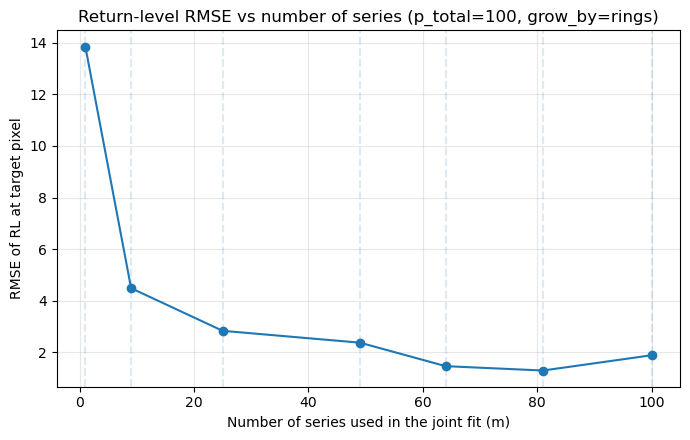

p_total: 100
First few (m, RMSE): [(1, 13.854850816076164), (9, 4.4891190791723865), (25, 2.8370633117821744), (49, 2.377994595212918), (64, 1.467283867653666)]
Final (all series) RMSE: 1.8908514230692361


In [ ]:
def compute_rl_rmse_progressive(
    generate_fn, gen_kwargs, i, j,
    n_runs=100, T=100, t_idx=25,
    n_jobs_runs=1, backend="threading",
    select_strategy="grid",  # "grid" (first K) or "random"
    base_seed=2025, verbose=True,
):
    """
    Progressively include more time series in the joint fit (always keeping (i,j)),
    compute the RL RMSE at (i,j) for each subset size m, and return a summary.

    Returns:
      {
        'm_list': list of subset sizes,
        'rmse':   np.array of shape (len(m_list),),
        'mse':    np.array of shape (len(m_list),),
        'n_successful': np.array,
        'success_rate': np.array,
        'mean_true': np.array,
        'per_m': [
            {
              'rl_hats': (n_runs,), 'rl_trues': (n_runs,),
              'errors': list length n_runs (None or str)
            }, ...
        ],
        'meta': {'p_total': int, 'target_s_idx': int}
      }
    """
    # --- quick probe to know dimensions ---
    _probe_data, _probe_meta = generate_fn(**gen_kwargs, seed=base_seed)
    n_time, n_lat, n_lon = _probe_data.shape
    p_total = n_lat * n_lon
    target_s_idx = i * n_lon + j

    # Build progressive sizes: 1..p_total
    m_list = list(range(1, p_total + 1))

    def choose_subset(m, rng):
        """Return a sorted array of series indices of length m including target_s_idx."""
        if m == 1:
            return np.array([target_s_idx], dtype=int)
        if select_strategy == "random":
            # sample the remaining m-1 from others
            others = np.setdiff1d(np.arange(p_total), np.array([target_s_idx]))
            pick = rng.choice(others, size=m-1, replace=False)
            subset = np.concatenate([[target_s_idx], pick])
        else:
            # "grid": take first m-1 plus the target, ensuring uniqueness
            base = np.arange(m)
            if target_s_idx not in base:
                subset = np.unique(np.concatenate([base, [target_s_idx]])).astype(int)
                # if we now have m+1 due to uniqueness, drop the last non-target
                if subset.size > m:
                    subset = subset[subset != target_s_idx][:m-1]
                    subset = np.sort(np.concatenate([[target_s_idx], subset]))
            else:
                subset = base
        return np.sort(subset.astype(int))

    def one_run_one_m(run_idx, m):
        seed = base_seed + run_idx
        try:
            data, meta = generate_fn(**gen_kwargs, seed=seed)  # (n_time, n_lat, n_lon)
            n_time, n_lat, n_lon = data.shape
            p_total = n_lat * n_lon
            s_idx = i * n_lon + j

            endog_all = data.reshape(n_time, p_total).astype(float)

            # subset selection (reproducible per (run,m))
            rng = np.random.default_rng(seed * 100003 + m)
            subset = choose_subset(m, rng)
            # index of target within subset
            try:
                s_in_subset = int(np.where(subset == s_idx)[0][0])
            except IndexError:
                # Safety: enforce inclusion if something went odd
                subset[0] = s_idx
                subset = np.sort(subset)
                s_in_subset = int(np.where(subset == s_idx)[0][0])

            endog = endog_all[:, subset]  # (n_time, m)

            # exogenous: time covariate, broadcast to m series
            t_curve = np.asarray(meta["t_curve"], float).reshape(n_time, 1)        # (n_time, 1)
            loc_X   = np.repeat(t_curve[:, :, None], m, axis=2)                    # (n_time, 1, m)
            exog = {"location": loc_X, "scale": None, "shape": None}

            # true RL at (i,j), t_idx
            p_nonexc = 1.0 - 1.0 / float(T)
            mu   = float(meta["mu"][t_idx][i, j])
            sig  = float(meta["sigma"][t_idx][i, j])
            xi   = float(meta["xi"][t_idx][i, j])
            rl_true = float(genextreme.ppf(p_nonexc, c=-xi, loc=mu, scale=sig))

            # fit and get RL_hat
            model = GEV(endog=endog, exog=exog)
            fit   = model._fit_mle_jax()
            z, lo, hi = fit.get_return_levels(T=[T], t=[t_idx], s=[s_in_subset], confidence=0.95)
            rl_hat = float(z[0, 0, 0])

            return m, run_idx, rl_hat, rl_true, None
        except Exception as e:
            return m, run_idx, np.nan, np.nan, repr(e)

    def aggregate_one_m(m):
        # run over runs for a fixed m
        if n_jobs_runs == 1:
            res = [one_run_one_m(r, m) for r in range(n_runs)]
        else:
            res = Parallel(n_jobs=n_jobs_runs, backend=backend, verbose=0)(
                delayed(one_run_one_m)(r, m) for r in range(n_runs)
            )
        rl_hats  = np.full(n_runs, np.nan)
        rl_trues = np.full(n_runs, np.nan)
        errors   = [None] * n_runs
        for _, r, hat, tru, err in res:
            rl_hats[r]  = hat
            rl_trues[r] = tru
            errors[r]   = err
        valid = np.isfinite(rl_hats) & np.isfinite(rl_trues)
        n_success = int(valid.sum())
        success_rate = n_success / float(n_runs)
        if n_success == 0:
            mse = rmse = mean_true = np.nan
        else:
            diff = rl_hats[valid] - rl_trues[valid]
            mse  = float(np.mean(diff**2))
            rmse = float(np.sqrt(mse))
            mean_true = float(np.mean(rl_trues[valid]))
        if verbose:
            print(f"m={m:4d}/{p_total}: success={n_success}/{n_runs} ({success_rate:.1%})  RMSE={rmse:.4g}")
        return {
            "m": m,
            "mse": mse,
            "rmse": rmse,
            "n_successful": n_success,
            "success_rate": success_rate,
            "mean_true": mean_true,
            "rl_hats": rl_hats,
            "rl_trues": rl_trues,
            "errors": errors,
        }

    # loop m
    per_m = [aggregate_one_m(m) for m in m_list]
    rmse = np.array([d["rmse"] for d in per_m], dtype=float)
    mse  = np.array([d["mse"]  for d in per_m], dtype=float)
    n_successful = np.array([d["n_successful"] for d in per_m], dtype=int)
    success_rate = np.array([d["success_rate"]  for d in per_m], dtype=float)
    mean_true    = np.array([d["mean_true"]     for d in per_m], dtype=float)

    return {
        "m_list": m_list,
        "rmse": rmse,
        "mse": mse,
        "n_successful": n_successful,
        "success_rate": success_rate,
        "mean_true": mean_true,
        "per_m": per_m,
        "meta": {"p_total": p_total, "target_s_idx": target_s_idx},
    }

def plot_rmse_progressive(res, title="RL RMSE vs number of time series"):
    m = np.asarray(res["m_list"])
    rmse = np.asarray(res["rmse"], float)
    p_total = res["meta"]["p_total"]

    fig = plt.figure(figsize=(7,4.5))
    plt.plot(m, rmse, marker="o")
    plt.xlabel("Number of series used in the joint fit (m)")
    plt.ylabel("RMSE of RL at target pixel")
    plt.title(title + f" (p_total={p_total})")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    return fig


In [34]:

import numpy as np
from sklearn.model_selection import train_test_split

def coef_fields_to_params(loc_coef, sca_coef, xi_coef, t_curve):
    """
    Build μ̂, σ̂, ξ̂ from coefficient rasters and the time covariate t'(t).
    Assumes identity link for σ (your current setup).
    """
    t_curve = np.asarray(t_curve, dtype=np.float32)
    T = t_curve.shape[0]
    H, W, Lmu = loc_coef.shape
    Lsg = sca_coef.shape[2]

    mu0    = loc_coef[:, :, 0]
    betaMu = loc_coef[:, :, 1] if Lmu > 1 else 0.0

    s0     = sca_coef[:, :, 0]
    betaS  = sca_coef[:, :, 1] if Lsg > 1 else 0.0

    mu_hat  = np.empty((T, H, W), dtype=np.float32)
    sig_hat = np.empty_like(mu_hat)
    for k in range(T):
        mu_hat[k]  = mu0  + betaMu * t_curve[k]
        sig_hat[k] = s0   + betaS  * t_curve[k]

    # ξ̂ is time-constant per pixel for this fit; broadcast over time
    xi_grid = xi_coef[:, :, 0].astype(np.float32)
    xi_hat  = np.broadcast_to(xi_grid[None, :, :], (T, H, W)).copy()

    # safety
    sig_hat = np.maximum(sig_hat, 1e-6)
    return mu_hat, sig_hat, xi_hat

# 2) Build fitted parameter fields from your coefficients
mu_hat, sig_hat, xi_hat = coef_fields_to_params(loc_coef, sca_coef, xi_coef, meta["t_curve"])

# 3) Flatten over (t,i,j)
def flatten3(a3): return a3.reshape(-1).astype(np.float32)

y_flat        = flatten3(data)      # observed
mu_hat_flat   = flatten3(mu_hat)
sig_hat_flat  = flatten3(sig_hat)
xi_hat_flat   = flatten3(xi_hat)

# 4) Simple random split (80/10/10)
idx_all = np.arange(y_flat.shape[0])
idx_tr, idx_tmp = train_test_split(idx_all, test_size=0.20, random_state=42, shuffle=True)
idx_val, idx_te = train_test_split(idx_tmp, test_size=0.50, random_state=42, shuffle=True)

# 5) Build arrays for the network
#    - query “locations” for distances = μ̂
#    - teachers = fitted params (consistent with your earlier RL usage)
mu_query_tr   = mu_hat_flat[idx_tr]
mu_query_val  = mu_hat_flat[idx_val]
mu_query_te   = mu_hat_flat[idx_te]

mu_teacher_tr     = mu_hat_flat[idx_tr]
sigma_teacher_tr  = sig_hat_flat[idx_tr]
xi_teacher_tr     = xi_hat_flat[idx_tr]
y_tr              = y_flat[idx_tr]

mu_teacher_val    = mu_hat_flat[idx_val]
sigma_teacher_val = sig_hat_flat[idx_val]
xi_teacher_val    = xi_hat_flat[idx_val]
y_val             = y_flat[idx_val]

mu_teacher_te     = mu_hat_flat[idx_te]
sigma_teacher_te  = sig_hat_flat[idx_te]
xi_teacher_te     = xi_hat_flat[idx_te]
y_te              = y_flat[idx_te]

In [46]:
# ============================ μ, logσ, ξ 3-feature kernel + Gumbel7-NLL + ESS ============================
import numpy as np
import torch
import torch.nn as tnn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[PyTorch] device: {device}")

# ---------- helpers: sampling, distances, ESS ----------
EPS = 1e-8

@torch.inference_mode()
def estimate_global_dist_scale(locs: torch.Tensor, num_pairs: int = 200_000) -> torch.Tensor:
    """Robust scale for pairwise distances: median over a random subset of pairs. locs: (N,D)"""
    N = locs.shape[0]
    if N < 2:
        return torch.tensor(1.0, device=locs.device)
    M = min(num_pairs, max(1, N*(N-1)))
    i = torch.randint(0, N, (M,), device=locs.device)
    j = torch.randint(0, N-1, (M,), device=locs.device)
    j = j + (j >= i).long()  # skip-self trick
    d = torch.linalg.norm(locs[i] - locs[j], dim=-1)
    return torch.median(d)

def sample_uniform_partners(batch_query_idx: torch.Tensor, K: int, N: int) -> torch.Tensor:
    B = batch_query_idx.shape[0]
    partners = torch.empty((B, K), dtype=torch.long, device=batch_query_idx.device)
    for b in range(B):
        q = int(batch_query_idx[b].item())
        idx = torch.randperm(N - 1, device=batch_query_idx.device)[:K]
        partners[b] = idx + (idx >= q)
    return partners

def rowwise_dists(locs: torch.Tensor, query_idx: torch.Tensor, partner_idx: torch.Tensor) -> torch.Tensor:
    """||loc[q]-loc[i]|| for each (q,i). locs: (N,D), q: (B,), i: (B,K) -> (B,K)"""
    qloc = locs.index_select(0, query_idx).unsqueeze(1)  # (B,1,D)
    ploc = locs.index_select(0, partner_idx.view(-1)).view(partner_idx.shape + (locs.shape[1],))  # (B,K,D)
    return torch.linalg.norm(ploc - qloc, dim=-1)        # (B,K)

@torch.inference_mode()
def ess_rows_from_raw(W: torch.Tensor) -> torch.Tensor:
    row_sum = torch.sum(W, dim=1) + EPS
    return (row_sum * row_sum) / (torch.sum(W * W, dim=1) + EPS)

# ---------- Gumbel (ξ=0) NLL ----------
# ---------- GEV NLL (stable, with ξ→0 branch) ----------
def rowsum_normalize_masked(W_raw: torch.Tensor, mask: torch.Tensor, eps: float = 1e-8) -> torch.Tensor:
    """
    Normalize per row after zeroing out masked entries.
    If a row has no valid entries, return zeros in that row (caller will handle).
    """
    Wm = W_raw * mask
    s = Wm.sum(dim=1, keepdim=True)
    W = torch.where(s > eps, Wm / s.clamp_min(eps), torch.zeros_like(Wm))
    return W, (s.squeeze(1) <= eps)  # no_valid: (B,)

# ---------- GEV NLL with domain masking and safe fallback ----------
def query_weighted_gev_nll_loss(W_raw: torch.Tensor,
                                mu_n: torch.Tensor,
                                sigma_n: torch.Tensor,
                                xi_n: torch.Tensor,
                                y_q: torch.Tensor,
                                *,
                                sigma_min: float = 1e-5,   # a bit higher to avoid huge z
                                xi_eps: float = 1e-6,
                                t_min: float = 1e-12,
                                exp_clip: float = 40.0) -> torch.Tensor:
    """
    Weighted GEV NLL with:
      - domain mask (t>0) before weight normalization,
      - ξ→0 Gumbel limit branch,
      - row-level fallback to Gumbel when no valid partners exist.
    Shapes:
      *_n and W_raw: (B,K), y_q: (B,)
    """
    B, K = W_raw.shape
    y  = y_q.view(B, 1)
    beta = sigma_n.clamp_min(sigma_min)
    xi   = xi_n

    # ξ≈0 branch precomputed (valid everywhere)
    z = (y - mu_n) / beta
    nll_gumbel = torch.log(beta) + z + torch.exp(torch.clamp(-z, max=exp_clip))

    # General GEV branch
    t = 1.0 + xi * (y - mu_n) / beta                 # support requires t > 0
    valid = t > 0.0

    # stable branch decision for ξ
    small_xi = xi.abs() < xi_eps
    large_xi = ~small_xi

    # GEV NLL where ξ≠0 and valid
    t_clamped = torch.clamp(t, min=t_min)
    log_t = torch.log(t_clamped)
    inv_xi = torch.empty_like(xi)
    inv_xi[large_xi] = 1.0 / xi[large_xi]

    pow_term = torch.zeros_like(log_t)
    pow_term[large_xi] = torch.exp(torch.clamp(-inv_xi[large_xi] * log_t[large_xi],
                                               min=-exp_clip, max=exp_clip))
    nll_gev = torch.log(beta) + (1.0 + inv_xi) * log_t + pow_term

    # per-pair NLL: use GEV where valid & ξ≠0; use Gumbel otherwise
    use_gev = valid & large_xi
    nll_pair = torch.where(use_gev, nll_gev, nll_gumbel)

    # normalize weights AFTER masking invalid pairs
    W, no_valid_row = rowsum_normalize_masked(W_raw, valid.float())

    # rows with no valid partners: fall back to Gumbel weighting (no masking)
    if no_valid_row.any():
        W_fallback = rowsum_normalize(W_raw)
        # compute row losses
        loss_rows = (W * nll_pair).sum(dim=1)  # default rows
        # fallback rows recomputed with gumbel nll and W_fallback
        loss_rows_fallback = (W_fallback * nll_gumbel).sum(dim=1)
        loss_rows = torch.where(no_valid_row, loss_rows_fallback, loss_rows)
        return loss_rows.mean()

    # normal case
    return (W * nll_pair).sum(dim=1).mean()

def rowsum_normalize(W: torch.Tensor, eps: float = 1e-8) -> torch.Tensor:
    return W / (W.sum(dim=1, keepdim=True).clamp_min(eps))

# ---------- tiny kernel net (now takes 3 features) ----------
class DynamicWeightNet(tnn.Module):
    """Input: (B,3) features [d_μ, d_logσ, d_ξ] -> Output: (B,1) weight in (0,1)."""
    def __init__(self, in_dim=3, hidden_dims=(32, 16), bias_init=0.8):
        super().__init__()
        layers, last = [], in_dim
        for h in hidden_dims:
            layers += [tnn.Linear(last, h), tnn.ReLU()]
            last = h
        self.backbone = tnn.Sequential(*layers)
        self.out = tnn.Linear(last, 1)
        with torch.no_grad():
            self.out.bias.fill_(bias_init)  # sigmoid(0.8) ~ 0.69

    def forward(self, x):  # x: (B,3)
        return torch.sigmoid(self.out(self.backbone(x)))

# ============================ tensors from your arrays ============================
# expects: mu_query_tr, y_tr, mu_teacher_tr, sigma_teacher_tr, xi_teacher_tr  (NumPy arrays)

locs_train_t    = torch.from_numpy(mu_query_tr.astype(np.float32)).to(device).unsqueeze(1)  # (N,1) for μ
y_train_t       = torch.from_numpy(y_tr.astype(np.float32)).to(device)
mu_teacher_t    = torch.from_numpy(mu_teacher_tr.astype(np.float32)).to(device)
sigma_teacher_t = torch.from_numpy(sigma_teacher_tr.astype(np.float32)).to(device)
xi_train_t      = torch.from_numpy(xi_teacher_tr.astype(np.float32)).to(device)             # (N,)

# --- log-σ for the second feature ---
log_sigma_train_t = torch.log(sigma_teacher_t.clamp_min(1e-12))                              # (N,)

# robust scales (train only)
with torch.inference_mode():
    mu_scale     = estimate_global_dist_scale(locs_train_t)                   # median |Δμ|
    logsig_scale = estimate_global_dist_scale(log_sigma_train_t.view(-1,1))   # median |Δlogσ|
    xi_scale     = estimate_global_dist_scale(xi_train_t.view(-1,1))          # median |Δξ|
print(f"[scales] med |Δμ|={float(mu_scale):.6f} | med |Δlogσ|={float(logsig_scale):.6f} | med |Δξ|={float(xi_scale):.6f}")

# ============================ training with ESS-based early stop ============================
K_SAMPLES         = 1000
epochs            = 300
batch_size        = 206
lr                = 1e-4
patience          = 300
ESS_MIN_THRESHOLD = 100
ESS_SAMPLE_SIZE   = 250

net   = DynamicWeightNet(in_dim=3).to(device)
optim = torch.optim.Adam(net.parameters(), lr=lr)

N = locs_train_t.shape[0]
best_train_loss = float('inf')
best_state = {k: v.detach().cpu().clone() for k, v in net.state_dict().items()}
patience_counter = 0

def _build_features(q_idx, i_idx):
    """
    Returns X: (B*K, 3) with columns:
      d_μ       = ((Δμ)^2)        / med(|Δμ|)^2
      d_logσ    = ((Δlogσ)^2)     / med(|Δlogσ|)^2
      d_ξ       = ((Δξ)^2)        / med(|Δξ|)^2
    """
    # μ feature
    d_mu = rowwise_dists(locs_train_t, q_idx, i_idx)                              # (B,K)
    f_mu = (d_mu ** 2) / ((mu_scale ** 2) + 1e-8)

    # logσ feature
    logsig_q = log_sigma_train_t.index_select(0, q_idx).unsqueeze(1)              # (B,1)
    logsig_i = log_sigma_train_t.index_select(0, i_idx.view(-1)).view_as(f_mu)    # (B,K)
    d_lsig   = torch.abs(logsig_i - logsig_q)
    f_lsig   = (d_lsig ** 2) / ((logsig_scale ** 2) + 1e-8)

    # ξ feature
    xi_q = xi_train_t.index_select(0, q_idx).unsqueeze(1)                          # (B,1)
    xi_i = xi_train_t.index_select(0, i_idx.view(-1)).view_as(f_mu)                # (B,K)
    d_xi = torch.abs(xi_i - xi_q)
    f_xi = (d_xi ** 2) / ((xi_scale ** 2) + 1e-8)

    X = torch.stack([f_mu, f_lsig, f_xi], dim=-1).reshape(-1, 3)                   # (B*K,3)
    return X, f_mu.shape  # shape is (B,K)

print(f"\nTraining 3-feature kernel with ESS early stop (threshold={ESS_MIN_THRESHOLD})...")
for epoch in range(1, epochs+1):
    net.train()
    prev_state_epoch = {k: v.detach().cpu().clone() for k, v in net.state_dict().items()}  # for ESS revert

    perm = torch.randperm(N, device=device)
    epoch_loss, num_batches = 0.0, int(np.ceil(N / batch_size))

    for b in range(num_batches):
        s, e = b*batch_size, min((b+1)*batch_size, N)
        if s >= e: continue

        q_idx = perm[s:e]                                        # (B,)
        yq    = y_train_t.index_select(0, q_idx)                 # (B,)
        i_idx = sample_uniform_partners(q_idx, K_SAMPLES, N)     # (B,K)

        # ----- build 3-feature inputs -----
        X, bk_shape = _build_features(q_idx, i_idx)              # X: (B*K,3), bk_shape=(B,K)

        # teacher params for partners
        mu_b    = mu_teacher_t.index_select(0, i_idx.view(-1)).view(bk_shape)
        sigma_b = sigma_teacher_t.index_select(0, i_idx.view(-1)).view(bk_shape)
        xi_b    = xi_train_t.index_select(0, i_idx.view(-1)).view(bk_shape) 
        # weights
        W_raw = net(X).view(bk_shape)                            # (B,K)

        # Gumbel NLL (ξ=0) — loss unchanged
        loss  = query_weighted_gev_nll_loss(W_raw, mu_b, sigma_b, xi_b, yq)

        optim.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
        optim.step()

        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / max(1, num_batches)

    # --------- ESS early stop (raw weights, no masking) ---------
    net.eval()
    with torch.no_grad():
        M = int(min(ESS_SAMPLE_SIZE, N))
        sample_q = torch.randperm(N, device=device)[:M]                 # (M,)
        sample_i = sample_uniform_partners(sample_q, K_SAMPLES, N)      # (M,K)
        Xs, mk_shape = _build_features(sample_q, sample_i)              # (M*K,3), (M,K)
        W_s = net(Xs).view(mk_shape)                                    # (M,K)
        mean_ess = float(torch.mean(ess_rows_from_raw(W_s)).item())

    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} | train NLL: {avg_train_loss:.6f} | mean ESS ≈ {mean_ess:.1f}")

    if mean_ess < ESS_MIN_THRESHOLD:
        print(f"\n!!! Early stopping: mean ESS {mean_ess:.1f} < threshold {ESS_MIN_THRESHOLD:.1f}. "
              f"Reverting to previous epoch state. !!!")
        net.load_state_dict(prev_state_epoch)
        best_state = prev_state_epoch
        break

    if avg_train_loss < best_train_loss:
        best_train_loss = avg_train_loss
        best_state = {k: v.detach().cpu().clone() for k, v in net.state_dict().items()}
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Training stopped early at epoch {epoch}.")
            break

# restore best
net.load_state_dict(best_state)
print(f"Final best train NLL: {best_train_loss:.6f}")
# =====================================================================================================


[PyTorch] device: cuda
[scales] med |Δμ|=5.070984 | med |Δlogσ|=0.081176 | med |Δξ|=0.075789

Training 3-feature kernel with ESS early stop (threshold=100)...
Epoch 010 | train NLL: 4.413404 | mean ESS ≈ 977.1
Epoch 020 | train NLL: 4.204812 | mean ESS ≈ 815.7
Epoch 030 | train NLL: 4.124642 | mean ESS ≈ 634.4
Epoch 040 | train NLL: 4.083916 | mean ESS ≈ 449.4
Epoch 050 | train NLL: 4.062253 | mean ESS ≈ 345.1
Epoch 060 | train NLL: 4.049255 | mean ESS ≈ 282.5
Epoch 070 | train NLL: 4.039964 | mean ESS ≈ 219.3
Epoch 080 | train NLL: 4.032479 | mean ESS ≈ 176.0
Epoch 090 | train NLL: 4.026680 | mean ESS ≈ 142.0
Epoch 100 | train NLL: 4.022871 | mean ESS ≈ 105.4

!!! Early stopping: mean ESS 93.7 < threshold 100.0. Reverting to previous epoch state. !!!
Final best train NLL: 4.022216


In [39]:
import numpy as np
import torch

def make_kernel_weight(net, mu_scale, logsig_scale, xi_scale, *, eps=1e-8, output="numpy"):
    """
    kernel_weight(d_mu, d_logsig, d_xi) -> weight(s)
    - Accepts scalars or arrays (NumPy or Torch), broadcasts, and returns
      either NumPy (default), CPU torch, or Python float for scalar input.
    """
    device = next(net.parameters()).device
    scales_sq = torch.as_tensor(
        [float(mu_scale)**2, float(logsig_scale)**2, float(xi_scale)**2],
        dtype=torch.float32, device=device
    ) + eps

    @torch.inference_mode()
    def kernel_weight(d_mu, d_logsig, d_xi):
        dm = torch.as_tensor(d_mu, dtype=torch.float32, device=device)
        dl = torch.as_tensor(d_logsig, dtype=torch.float32, device=device)
        dx = torch.as_tensor(d_xi, dtype=torch.float32, device=device)
        dm, dl, dx = torch.broadcast_tensors(dm, dl, dx)

        feats = torch.stack([dm*dm, dl*dl, dx*dx], dim=-1) / scales_sq  # (...,3)

        net.eval()
        w = net(feats.reshape(-1, 3)).squeeze(-1).reshape(dm.shape)

        if output == "tensor":
            return w.detach().cpu()
        arr = w.detach().cpu().numpy()
        return float(arr) if arr.shape == () else arr

    return kernel_weight


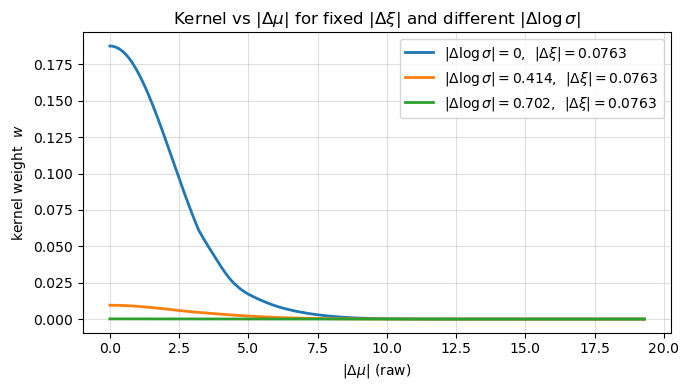

In [7]:
@torch.inference_mode()
def plot_kernel_vs_mu_distance(dynamic_net,
                               locs_train_t,                 # (N,1) for μ
                               mu_dist_scale,                # scalar tensor (median |Δμ|)
                               log_sigma_train_t,            # (N,)  log σ per item
                               logsig_dist_scale=None,       # scalar tensor (median |Δlogσ|); auto if None
                               xi_train_t=None,              # (N,)  ξ per item (optional but recommended)
                               xi_dist_scale=None,           # scalar tensor (median |Δξ|); auto if needed
                               *,
                               fixed_dxi="median",           # 0.0 | "median" | "p90" | float (raw |Δξ|)
                               squared: bool = True,
                               num_pairs: int = 200_000,
                               delta_logsig_vals="auto"      # "auto" -> [0, median, p90] or list of raw values
                               ):
    """
    Plots w(|Δμ|) for a 3-feature kernel [d_μ, d_logσ, d_ξ], with |Δξ| fixed.

    Features match training:
      d_μ       = ((Δμ)^2)        / med(|Δμ|)^2        if squared else (Δμ) / med(|Δμ|)
      d_logσ    = ((Δlogσ)^2)     / med(|Δlogσ|)^2     if squared else |Δlogσ| / med(|Δlogσ|)
      d_ξ       = ((Δξ)^2)        / med(|Δξ|)^2        if squared else |Δξ| / med(|Δξ|)
    """
    dynamic_net.eval()
    device = locs_train_t.device
    N = locs_train_t.shape[0]

    # ---- sample pairs to set sensible ranges and stats ----
    M = min(num_pairs, max(1, N*(N-1)))
    i = torch.randint(0, N, (M,), device=device)
    j = torch.randint(0, N-1, (M,), device=device); j = j + (j >= i).long()

    dmu_raw = torch.linalg.norm(locs_train_t[i] - locs_train_t[j], dim=-1)   # |Δμ|
    dls_raw = torch.abs(log_sigma_train_t[i] - log_sigma_train_t[j])         # |Δlogσ|

    # ranges for μ
    dmax = float(torch.quantile(dmu_raw, 0.99).item())
    dgrid = torch.linspace(0.0, dmax, steps=512, device=device)              # raw |Δμ| grid

    # μ feature along grid (match training)
    if squared:
        f_mu = (dgrid ** 2) / ((mu_dist_scale ** 2) + 1e-8)
    else:
        f_mu = dgrid / (mu_dist_scale + 1e-8)

    # scales for logsigma / xi if needed
    if logsig_dist_scale is None:
        logsig_dist_scale = estimate_global_dist_scale(log_sigma_train_t.view(-1,1))

    # resolve fixed |Δξ|
    if isinstance(fixed_dxi, str):
        key = fixed_dxi.lower()
        if xi_train_t is None and key != "0" and key != "zero":
            raise ValueError("xi_train_t must be provided unless fixed_dxi is 0.0")
        if key == "median":
            dxi_raw = torch.abs(xi_train_t[i] - xi_train_t[j]) if xi_train_t is not None else None
            fixed_xi_raw = float(torch.quantile(dxi_raw, 0.50).item()) if dxi_raw is not None else 0.0
        elif key in ("p90", "90", "0.9"):
            dxi_raw = torch.abs(xi_train_t[i] - xi_train_t[j]) if xi_train_t is not None else None
            fixed_xi_raw = float(torch.quantile(dxi_raw, 0.90).item()) if dxi_raw is not None else 0.0
        elif key in ("0", "zero"):
            fixed_xi_raw = 0.0
        else:
            raise ValueError(f"Unrecognized fixed_dxi spec: {fixed_dxi}")
    else:
        fixed_xi_raw = float(fixed_dxi)

    if abs(fixed_xi_raw) > 0 and xi_dist_scale is None:
        if xi_train_t is None:
            raise ValueError("xi_train_t required to auto-compute xi_dist_scale.")
        xi_dist_scale = estimate_global_dist_scale(xi_train_t.view(-1,1))

    # build constant ξ feature along the μ grid
    if abs(fixed_xi_raw) == 0:
        f_xi = torch.zeros_like(f_mu)
    else:
        if squared:
            fxi_scalar = (fixed_xi_raw ** 2) / ((xi_dist_scale ** 2) + 1e-8)
        else:
            fxi_scalar = fixed_xi_raw / (xi_dist_scale + 1e-8)
        f_xi = torch.full_like(f_mu, fxi_scalar)

    # choose |Δlogσ| slices
    if isinstance(delta_logsig_vals, str) and delta_logsig_vals.lower() == "auto":
        med_dls = float(torch.quantile(dls_raw, 0.50).item())
        p90_dls = float(torch.quantile(dls_raw, 0.75).item())
        slices = [0.0, med_dls, p90_dls]
    elif delta_logsig_vals is None:
        slices = [0.0]
    else:
        slices = list(delta_logsig_vals)

    import matplotlib.pyplot as plt
    plt.figure(figsize=(7,4))
    x_np = dgrid.detach().cpu().numpy()

    for dls in slices:
        dls = float(abs(dls))
        # σ feature (constant along μ grid), same transform as training
        if squared:
            fsig_scalar = (dls ** 2) / ((logsig_dist_scale ** 2) + 1e-8)
        else:
            fsig_scalar = dls / (logsig_dist_scale + 1e-8)
        f_sig = torch.full_like(f_mu, fsig_scalar)

        # assemble inputs in model order: [d_μ, d_logσ, d_ξ]
        X = torch.stack([f_mu, f_sig, f_xi], dim=-1)    # (512, 3)
        w = dynamic_net(X).squeeze(1).detach().cpu().numpy()

        plt.plot(x_np, w, lw=2,
                 label=rf'$|\Delta \log \sigma|={dls:.3g}$,  $|\Delta \xi|={fixed_xi_raw:.3g}$')

    plt.xlabel(r'$|\Delta \mu|$ (raw)')
    plt.ylabel(r'kernel weight  $w$')
    title = r'Kernel vs $|\Delta \mu|$ for fixed $|\Delta \xi|$ and different $|\Delta \log \sigma|$'
    plt.title(title)
    plt.grid(True, alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Build the auxiliaries once:
log_sigma_train_t = torch.log(sigma_teacher_t.clamp_min(1e-12))  # (N,)
# If you kept the old name:
dist_scale = mu_scale  # alias

plot_kernel_vs_mu_distance(
    net,
    locs_train_t,
    dist_scale,                 # = mu_scale
    log_sigma_train_t,          # required (for |Δlogσ| slices)
    logsig_dist_scale=None,     # auto
    xi_train_t=xi_train_t,      # required to fix nonzero |Δξ|
    xi_dist_scale=None,         # auto if needed
    fixed_dxi="median",         # fix |Δξ| at dataset median; or 0.0, "p90", or a float
    squared=True,
    delta_logsig_vals="auto"    # curves at 0, median, 90th-percentile |Δlogσ|
)


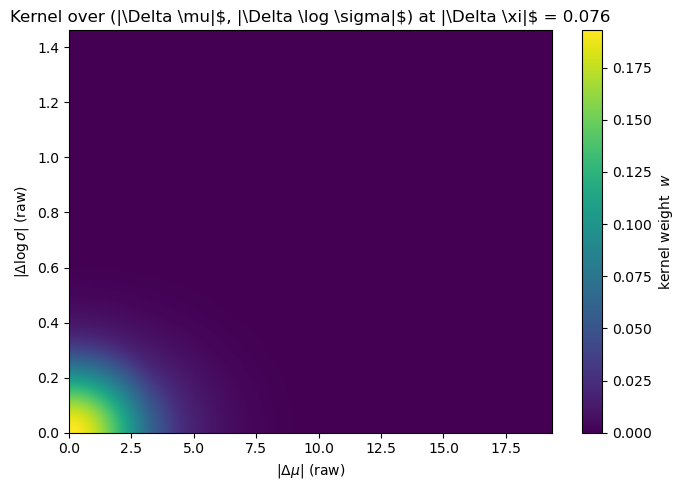

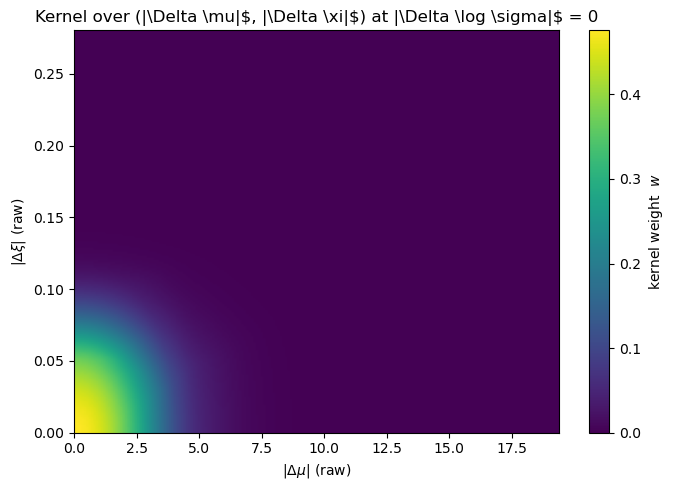

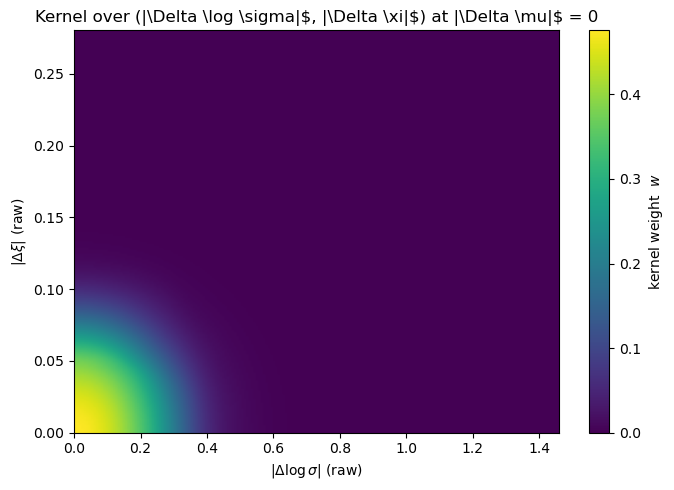

In [8]:
@torch.inference_mode()
def plot_kernel_heatmap(dynamic_net,
                        *,
                        # data tensors (provide the ones you need)
                        locs_train_t=None,           # (N,1)  for μ
                        log_sigma_train_t=None,      # (N,)   for logσ
                        xi_train_t=None,             # (N,)   for ξ
                        # robust scales (pass or will auto-compute from data)
                        mu_dist_scale=None,
                        logsig_dist_scale=None,
                        xi_dist_scale=None,
                        # which variables on axes / fixed:
                        x_axis: str = "mu",          # one of {"mu","logsigma","xi"}
                        y_axis: str = "xi",          # one of {"mu","logsigma","xi"}
                        fixed: dict | None = None,   # e.g. {"logsigma": "median"} or {"mu": 0.0}
                        # viz/transform
                        squared: bool = True,
                        num_pairs: int = 200_000,
                        nx: int = 200,
                        ny: int = 200):
    """
    General heatmap for the 3-feature kernel [d_μ, d_logσ, d_ξ].
    - Varies x_axis and y_axis over raw deltas (99th percentile ranges from data).
    - Holds the remaining variable at a fixed raw delta: float, 0.0, "median", or "p90".
    - Transforms to features exactly like training (squared + robust scaling, or linear if squared=False).
    """
    dynamic_net.eval()

    # ---- helpers ----
    def _need(name):
        if name == "mu" and locs_train_t is None:
            raise ValueError("locs_train_t required for 'mu'.")
        if name == "logsigma" and log_sigma_train_t is None:
            raise ValueError("log_sigma_train_t required for 'logsigma'.")
        if name == "xi" and xi_train_t is None:
            raise ValueError("xi_train_t required for 'xi'.")

    def _device():
        for t in (locs_train_t, log_sigma_train_t, xi_train_t):
            if t is not None:
                return t.device
        return next(dynamic_net.parameters()).device

    def _sample_pairs(N):
        M = min(num_pairs, max(1, N*(N-1)))
        i = torch.randint(0, N, (M,), device=device)
        j = torch.randint(0, N-1, (M,), device=device)
        j = j + (j >= i).long()
        return i, j

    def _raw_delta(name, i, j):
        if name == "mu":
            return torch.linalg.norm(locs_train_t[i] - locs_train_t[j], dim=-1)
        elif name == "logsigma":
            return torch.abs(log_sigma_train_t[i] - log_sigma_train_t[j])
        elif name == "xi":
            return torch.abs(xi_train_t[i] - xi_train_t[j])
        else:
            raise ValueError(f"Unknown var '{name}'")

    def _scale_of(name):
        nonlocal mu_dist_scale, logsig_dist_scale, xi_dist_scale
        if name == "mu":
            if mu_dist_scale is None:
                mu_dist_scale = estimate_global_dist_scale(locs_train_t)
            return mu_dist_scale
        if name == "logsigma":
            if logsig_dist_scale is None:
                logsig_dist_scale = estimate_global_dist_scale(log_sigma_train_t.view(-1,1))
            return logsig_dist_scale
        if name == "xi":
            if xi_dist_scale is None:
                xi_dist_scale = estimate_global_dist_scale(xi_train_t.view(-1,1))
            return xi_dist_scale

    def _to_feature(name, raw):
        s = _scale_of(name)
        if squared:
            return (raw ** 2) / ((s ** 2) + 1e-8)
        else:
            return raw / (s + 1e-8)

    def _axis_grid(name, max_raw, steps):
        g = torch.linspace(0.0, max_raw, steps=steps, device=device)
        return g

    def _resolve_fixed(name, i, j):
        if fixed is None or name not in fixed:
            # default: use median if we can, else 0.0
            try:
                return float(torch.quantile(_raw_delta(name, i, j), 0.50).item())
            except Exception:
                return 0.0
        val = fixed[name]
        if isinstance(val, (int, float)):
            return float(val)
        key = str(val).lower()
        if key == "median":
            return float(torch.quantile(_raw_delta(name, i, j), 0.50).item())
        if key in ("p90", "90", "0.9"):
            return float(torch.quantile(_raw_delta(name, i, j), 0.90).item())
        if key in ("zero", "0"):
            return 0.0
        raise ValueError(f"Unrecognized fixed value spec: {val}")

    # ---- setup & validations ----
    x_axis = x_axis.lower()
    y_axis = y_axis.lower()
    axes = {"mu", "logsigma", "xi"}
    if x_axis not in axes or y_axis not in axes or x_axis == y_axis:
        raise ValueError("x_axis and y_axis must be distinct in {'mu','logsigma','xi'}")

    fixed_var = list(axes - {x_axis, y_axis})[0]
    _need(x_axis); _need(y_axis); _need(fixed_var)

    device = _device()
    # determine N from any provided tensor
    N = None
    for t in (locs_train_t, log_sigma_train_t, xi_train_t):
        if t is not None:
            N = t.shape[0]
            break
    if N is None:
        raise ValueError("No data tensors provided.")

    # sample for ranges & fixed raw
    i, j = _sample_pairs(N)
    x_raw = _raw_delta(x_axis, i, j)
    y_raw = _raw_delta(y_axis, i, j)
    x_max = float(torch.quantile(x_raw, 0.99).item())
    y_max = float(torch.quantile(y_raw, 0.99).item())
    fixed_raw = _resolve_fixed(fixed_var, i, j)

    # build axis grids in raw units
    gx = _axis_grid(x_axis, x_max, nx)   # (nx,)
    gy = _axis_grid(y_axis, y_max, ny)   # (ny,)
    GY, GX = torch.meshgrid(gy, gx, indexing='ij')  # (ny,nx)

    # convert to features in training space
    F_mu = torch.zeros_like(GX)
    F_sig = torch.zeros_like(GX)
    F_xi = torch.zeros_like(GX)

    # fill x & y
    if x_axis == "mu":       F_mu = _to_feature("mu", GX)
    if x_axis == "logsigma": F_sig = _to_feature("logsigma", GX)
    if x_axis == "xi":       F_xi = _to_feature("xi", GX)

    if y_axis == "mu":       F_mu = _to_feature("mu", GY) if F_mu.numel()==0 else _to_feature("mu", GY)
    if y_axis == "logsigma": F_sig = _to_feature("logsigma", GY)
    if y_axis == "xi":       F_xi = _to_feature("xi", GY)

    # set fixed var
    fixed_feat_scalar = _to_feature(fixed_var, torch.tensor(float(fixed_raw), device=device))
    if fixed_var == "mu":       F_mu = torch.full_like(GX, fixed_feat_scalar)
    if fixed_var == "logsigma": F_sig = torch.full_like(GX, fixed_feat_scalar)
    if fixed_var == "xi":       F_xi = torch.full_like(GX, fixed_feat_scalar)

    # assemble X in the model's expected order [d_mu, d_logσ, d_ξ]
    X = torch.stack([F_mu.reshape(-1), F_sig.reshape(-1), F_xi.reshape(-1)], dim=-1)  # (ny*nx,3)
    W = dynamic_net(X).reshape(ny, nx).detach().cpu().numpy()

    # labels
    axis_label = {
        "mu": r"$|\Delta \mu|$ (raw)",
        "logsigma": r"$|\Delta \log \sigma|$ (raw)",
        "xi": r"$|\Delta \xi|$ (raw)"
    }

    import matplotlib.pyplot as plt
    plt.figure(figsize=(7,5))
    extent = [0.0, x_max, 0.0, y_max]
    plt.imshow(W, origin='lower', aspect='auto', extent=extent)
    plt.colorbar(label='kernel weight  $w$')
    plt.xlabel(axis_label[x_axis])
    plt.ylabel(axis_label[y_axis])
    plt.title(rf"Kernel over ({axis_label[x_axis][1:-6]}, {axis_label[y_axis][1:-6]}) at "
              rf"{axis_label[fixed_var][1:-6]} = {fixed_raw:.3g}")
    plt.tight_layout()
    plt.show()
# prerequisites already in your script:
# locs_train_t, log_sigma_train_t = torch.log(sigma_teacher_t.clamp_min(1e-12)), xi_train_t
# mu_scale, logsig_scale, xi_scale computed earlier (or let the function auto-compute)


# 1) μ–ξ heatmap at median |Δlogσ|
plot_kernel_heatmap(
    net,
    locs_train_t=locs_train_t,
    log_sigma_train_t=log_sigma_train_t,
    xi_train_t=xi_train_t,
    mu_dist_scale=mu_scale,
    logsig_dist_scale=logsig_scale,
    xi_dist_scale=xi_scale,
    x_axis="mu", y_axis="logsigma",
    fixed={"logsigma": "zero"},
    squared=True
)


# 1) μ–ξ heatmap at median |Δlogσ|
plot_kernel_heatmap(
    net,
    locs_train_t=locs_train_t,
    log_sigma_train_t=log_sigma_train_t,
    xi_train_t=xi_train_t,
    mu_dist_scale=mu_scale,
    logsig_dist_scale=logsig_scale,
    xi_dist_scale=xi_scale,
    x_axis="mu", y_axis="xi",
    fixed={"logsigma": "zero"},
    squared=True
)

# 2) σ–ξ heatmap at median |Δμ|
plot_kernel_heatmap(
    net,
    locs_train_t=locs_train_t,
    log_sigma_train_t=log_sigma_train_t,
    xi_train_t=xi_train_t,
    mu_dist_scale=mu_scale,
    logsig_dist_scale=logsig_scale,
    xi_dist_scale=xi_scale,
    x_axis="logsigma", y_axis="xi",
    fixed={"mu": "zero"},
    squared=True
)


In [14]:
def kernel_features_pair(meta, i, j, pi, pj,
                         mu_scale, logsig_scale, xi_scale,
                         *, use_time_mean=True, t_ref=None, squared=True):
    """
    Build [d_mu, d_logsig, d_xi] features for target (i,j) vs partner (pi,pj),
    using the SAME transforms you trained on. Returns np.array shape (3,).
    """
    if use_time_mean:
        MU  = meta["mu"].mean(axis=0)      # (H,W)
        SIG = meta["sigma"].mean(axis=0)
        XI  = meta["xi"].mean(axis=0)
    else:
        if t_ref is None:
            raise ValueError("t_ref required when use_time_mean=False")
        MU  = meta["mu"][t_ref]
        SIG = meta["sigma"][t_ref]
        XI  = meta["xi"][t_ref]

    mu_q,  mu_p  = float(MU[i, j]),  float(MU[pi, pj])
    ls_q,  ls_p  = float(np.log(max(SIG[i, j], 1e-12))), float(np.log(max(SIG[pi, pj], 1e-12)))
    xi_q,  xi_p  = float(XI[i, j]),  float(XI[pi, pj])

    dmu = abs(mu_p - mu_q)
    dls = abs(ls_p - ls_q)
    dxi = abs(xi_p - xi_q)

    if squared:
        f_mu  = (dmu**2) / (float(mu_scale)**2 + 1e-8)
        f_lsg = (dls**2) / (float(logsig_scale)**2 + 1e-8)
        f_xi  = (dxi**2) / (float(xi_scale)**2 + 1e-8)
    else:
        f_mu  = dmu  / (float(mu_scale)    + 1e-8)
        f_lsg = dls  / (float(logsig_scale)+ 1e-8)
        f_xi  = dxi  / (float(xi_scale)    + 1e-8)

    return np.array([f_mu, f_lsg, f_xi], dtype=np.float32)

f = kernel_features_pair(meta, 0, 0 , 1, 0, mu_scale, logsig_scale, xi_scale)
f

array([0.05767902, 0.        , 0.        ], dtype=float32)

In [40]:
from matplotlib.animation import FuncAnimation

# ---------- small helper ----------
def _extent_from_meta(meta):
    if meta is not None and "x" in meta and "y" in meta:
        x = np.asarray(meta["x"]); y = np.asarray(meta["y"])
        return (x.min(), x.max(), y.min(), y.max())
    return None

@torch.inference_mode()
def _weight_map_from_mu_frame(dynamic_net, mu_frame_np, mu_q_scalar, dist_scale,
                              squared: bool = True, device=None,
                              lat_stride: int = 1, lon_stride: int = 1,
                              roi: tuple | None = None,  # (i_start, i_end, j_start, j_end)
                              use_fp16: bool = False):
    """
    One frame: spatial weights at a fixed time given a query μ.
    Returns (H',W') numpy map after ROI+stride.
    """
    if device is None:
        device = next(dynamic_net.parameters()).device

    if roi is not None:
        i0, i1, j0, j1 = roi
        mu_frame_np = mu_frame_np[i0:i1, j0:j1]
    mu_frame_np = mu_frame_np[::lat_stride, ::lon_stride]

    dtype = torch.float16 if (use_fp16 and device.type == "cuda") else torch.float32
    mu_frame = torch.from_numpy(mu_frame_np.astype(np.float32)).to(device=device, dtype=dtype)
    mu_q = torch.tensor(float(mu_q_scalar), device=device, dtype=dtype)

    d = torch.abs(mu_frame - mu_q)             # |Δμ|
    if squared:
        d = (d ** 2) / ((dist_scale ** 2) + 1e-8)
    else:
        d = d / (dist_scale + 1e-8)

    W = dynamic_net(d.reshape(-1, 1)).reshape_as(mu_frame)
    return W.detach().float().cpu().numpy()


# ======================= 1) 1D plot — fixed (i0,j0), ref time moves =======================
@torch.inference_mode()
def animate_temporal_1d_for_pixel(dynamic_net, mu_hat, dist_scale,
                                  i0: int, j0: int,
                                  squared: bool = True,
                                  t_step: int = 1, max_frames: int | None = None,
                                  fps: int = 10, save_path: str | None = None):
    """
    For pixel (i0,j0), show weights vs *all times*; the reference time moves across frames.
    """
    dynamic_net.eval()
    device = next(dynamic_net.parameters()).device
    mu_line = mu_hat[:, i0, j0].astype(np.float32)  # (T,)
    T = mu_line.shape[0]

    t_list = list(range(0, T, t_step))
    if max_frames is not None:
        t_list = t_list[:max_frames]

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.set_xlim(0, T-1); ax.set_ylim(0, 1)
    ax.set_xlabel("time index"); ax.set_ylabel("kernel weight")
    ax.grid(True, alpha=0.3)
    title = ax.set_title("")
    line, = ax.plot([], [], lw=2)
    marker = ax.scatter([], [], c="red", s=80, zorder=5)

    # prebuild torch tensor holder to avoid realloc per frame
    x_torch = torch.empty((T, 1), device=device, dtype=torch.float32)

    def _weights_for_ref(t_ref: int):
        # distances across time against the reference μ at this pixel
        d = np.abs(mu_line - mu_line[t_ref])
        if squared:
            x = (d ** 2) / ((float(dist_scale) ** 2) + 1e-8)
        else:
            x = d / (float(dist_scale) + 1e-8)
        x_torch[:, 0] = torch.from_numpy(x.astype(np.float32)).to(device)
        w = dynamic_net(x_torch).squeeze(1).detach().cpu().numpy()
        return w

    def _update(fi):
        t_ref = t_list[fi]
        w = _weights_for_ref(t_ref)
        line.set_data(np.arange(T), w)
        marker.set_offsets([t_ref, w[t_ref]])
        title.set_text(f"Temporal weights at (i={i0}, j={j0}) — ref t={t_ref}")
        return line, marker, title

    anim = FuncAnimation(fig, _update, frames=len(t_list),
                         interval=int(1000/fps), blit=False)
    plt.close(fig)
    if save_path:
        anim.save(save_path, writer="pillow", fps=fps)
        print(f"saved temporal 1D animation → {save_path}")
    return anim


# ======================= 2) 2D plot — fixed t0, ref pixel moves in space =======================
@torch.inference_mode()
def animate_spatial_2d_for_time(dynamic_net, mu_hat, dist_scale,
                                t0: int,
                                meta=None,
                                squared: bool = True,
                                lat_stride: int = 1, lon_stride: int = 1,
                                roi: tuple | None = None,      # (i_start,i_end,j_start,j_end)
                                path: str = "scan",            # "scan" (serpentine) or "random"
                                max_frames: int | None = None,
                                fps: int = 10,
                                vmax_quantile: float = 0.99,
                                use_fp16: bool = False,
                                save_path: str | None = None):
    """
    At fixed time t0, move the reference pixel across space; each frame shows a spatial weight heatmap.
    """
    dynamic_net.eval()
    T, H, W = mu_hat.shape
    extent = _extent_from_meta(meta)

    # build traversal order over (i,j)
    if path == "random":
        order = np.column_stack([
            np.random.randint(0, H, size=H*W),
            np.random.randint(0, W, size=H*W)
        ])
    else:  # serpentine scan with strides
        order = []
        for i in range(0, H, lat_stride):
            cols = list(range(0, W, lon_stride)) if (i // lat_stride) % 2 == 0 \
                   else list(range(W-1, -1, -lon_stride))
            for j in cols:
                order.append((i, j))
        order = np.array(order, dtype=int)

    if max_frames is not None:
        order = order[:max_frames]

    # probe some frames to set a stable vmax
    probe_idx = np.linspace(0, len(order)-1, num=min(40, len(order)), dtype=int)
    probe_vals = []
    for idx in probe_idx:
        i, j = order[idx]
        mu_q = float(mu_hat[t0, i, j])
        w = _weight_map_from_mu_frame(dynamic_net, mu_hat[t0], mu_q, dist_scale,
                                      squared=squared, lat_stride=lat_stride, lon_stride=lon_stride,
                                      roi=roi, use_fp16=use_fp16)
        probe_vals.append(w)
    vmax = float(np.quantile(np.array(probe_vals).ravel(), vmax_quantile)) if probe_vals else 1.0

    # determine displayed shape after ROI+stride
    if roi is None:
        Hs, Ws = H, W
    else:
        Hs, Ws = roi[1]-roi[0], roi[3]-roi[2]
    Hs = (Hs + lat_stride - 1) // lat_stride
    Ws = (Ws + lon_stride - 1) // lon_stride

    fig, ax = plt.subplots(figsize=(7,5))
    im = ax.imshow(np.zeros((Hs, Ws)), origin="lower", extent=extent, aspect="auto",
                   vmin=0, vmax=vmax, cmap="viridis", interpolation="none")
    fig.colorbar(im, ax=ax, label="kernel weight")
    ref_scatter = ax.scatter([], [], s=150, c="red", marker="*", edgecolor="black", zorder=5)
    title = ax.set_title("")

    def _update(fi):
        i, j = order[fi]
        mu_q = float(mu_hat[t0, i, j])
        w = _weight_map_from_mu_frame(dynamic_net, mu_hat[t0], mu_q, dist_scale,
                                      squared=squared, lat_stride=lat_stride, lon_stride=lon_stride,
                                      roi=roi, use_fp16=use_fp16)
        im.set_data(w)
        # update reference marker
        if extent is None:
            # image pixel coords (account for ROI/stride)
            ii = (i - (roi[0] if roi else 0)) // lat_stride
            jj = (j - (roi[2] if roi else 0)) // lon_stride
            ref_scatter.set_offsets([jj, ii])
        else:
            ref_scatter.set_offsets([float(meta["x"][j]), float(meta["y"][i])])
        title.set_text(f"Spatial weights — fixed t={t0}, ref=(i={i}, j={j})")
        return im, ref_scatter, title

    anim = FuncAnimation(fig, _update, frames=len(order),
                         interval=int(1000/fps), blit=False)
    plt.close(fig)
    if save_path:
        anim.save(save_path, writer="pillow", fps=fps)
        print(f"saved spatial 2D animation → {save_path}")
    return anim


In [32]:
# assumes:
#   net         ← trained DynamicWeightNet
#   mu_hat      ← fitted μ field, shape (T, H, W)
#   dist_scale  ← torch scalar (median |Δμ|) on the same device as net
#   meta        ← optional dict with 'x','y' for nice extents

# 1D temporal (ref time moves)
i0, j0 = 3, 5
anim_1d = animate_temporal_1d_for_pixel(
    net, mu_hat, dist_scale, i0, j0,
    squared=True, t_step=2, max_frames=80, fps=10,
    save_path="temporal_1d.gif"  # or "temporal_1d.gif"
)


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


IndexError: list index out of range

In [12]:
# 2D spatial (ref pixel moves) at fixed time
t0 = 35
anim_2d = animate_spatial_2d_for_time(
    net, mu_hat, dist_scale, t0,
    meta=meta,
    lat_stride=1, lon_stride=1,     # speed-up
    roi=None,                       # or (i_start,i_end,j_start,j_end)
    path="scan", max_frames=200, fps=2,
    save_path="spatial.gif"  # or "spatial_2d.gif"
)

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


saved spatial 2D animation → spatial.gif


In [41]:
# ==== Weighted multi-series GEV fit (all pixels), weights from μ-distance kernel ====
import numpy as np
import torch
from GEV import GEV

# --- 0) pick the space–time reference point for the weights ---
t_ref, i_ref, j_ref = 25, 1, 1   # change as you like

# --- 1) choose which μ-field to use for distances ---
def get_mu_field():
    # Prefer fitted μ if you computed it (e.g., from loc_coef or model output)
    if 'mu_hat' in globals():
        mu = np.asarray(mu_hat, dtype=np.float32)     # (T,H,W)
        assert mu.ndim == 3
        return mu
    # Or reconstruct from pointwise coefficients (μ = μ0 + βμ,t * t')
    if 'loc_coef' in globals() and 'meta' in globals():
        lc = np.asarray(loc_coef, np.float32)         # (H,W,2): [μ0, βμ,t]
        t_curve = np.asarray(meta['t_curve'], np.float32)  # (T,)
        mu = lc[..., 0][None, :, :] + lc[..., 1][None, :, :] * t_curve[:, None, None]
        return mu.astype(np.float32)
    # Fallback to the generator's true μ
    return np.asarray(meta['mu'], dtype=np.float32)

mu_field = get_mu_field()              # (T,H,W)
T, H, W_ = mu_field.shape
assert data.shape[:3] == (T, H, W_)

# --- 2) compute μ-distance to the reference for every (t,i,j) ---
mu_ref = float(mu_field[t_ref, i_ref, j_ref])
d_mu   = np.abs(mu_field - mu_ref).astype(np.float32)    # (T,H,W)

# --- 3) turn μ-distance into the same feature the kernel was trained on ---
kernel = dynamic_net if 'dynamic_net' in globals() else net
device = next(kernel.parameters()).device
with torch.inference_mode():
    x = torch.from_numpy(d_mu).to(device=device, dtype=torch.float32)  # (T,H,W)
    # If you trained with squared/median-normalized distance, keep it:
    x = (x**2) / (dist_scale**2 + 1e-8)
    w = kernel(x.view(-1, 1)).squeeze(1)                 # (T*H*W,)
    W_mat = w.detach().cpu().numpy().reshape(T, H*W_)    # (n_obs, n_samples)

# (optional) tiny floor for numerical safety
W_mat = np.maximum(W_mat, 1e-12)

# --- 4) build multi-series endog and exog (time-only) ---
Y = data.reshape(T, H*W_).astype(float)                  # (n_obs, n_samples)
X_t = meta['t_curve']                                    # length T (1-D is fine)
exog_time_only = {"location": None, "scale": None, "shape": None}

# --- 5) fit the weighted GEV across all pixels at once ---
model_all = GEV(endog=Y, exog=exog_time_only, weights=W_mat)   # identity links by default
fit_all   = model_all._fit_mle_jax()
print(fit_all)

# --- 6) (optional) RL plot for a specific pixel from the multi-series fit ---
# choose which pixel to visualize (use the same (i,j) or any other)
i_vis, j_vis = i_ref, j_ref
s_idx = i_vis * W_ + j_vis     # flatten index consistent with reshape(T, H*W)

T_list = [1.1, 5, 10, 50, 100, 150, 200, 300, 500]
t_list = [t_ref]

def _xi_at(meta, t=None, i=None, j=None):
    xi = meta.get("xi", 0.0)
    if np.isscalar(xi): return float(xi)
    arr = np.asarray(xi)
    if arr.ndim == 0: return float(arr)
    if arr.ndim == 1 and t is not None: return float(arr[t])
    if arr.ndim == 3 and None not in (t,i,j): return float(arr[t, i, j])
    return float(arr.ravel()[0])

manual_params = np.array([
    [ float(meta["mu"][t, i_vis, j_vis]),
      float(meta["sigma"][t, i_vis, j_vis]),
      _xi_at(meta, t=t, i=i_vis, j=j_vis) ]
    for t in t_list
], dtype=float)

fit_all.plot_return_levels(
    T=T_list, t=t_list, s=s_idx, show_ci=True,
    manual_params=manual_params,
    title=f"Weighted ALL-pixels GEV — view (i={i_vis}, j={j_vis}) | ref=({t_ref},{i_ref},{j_ref})"
)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (10000x1 and 3x32)